# Task 2: Model Implementation:
 
1. Define and justify a clinically meaningful approach to modelling time to death. 
2. Cohort Construction: Build your patient-level cohort from admissions.csv, patients.csv, and optionally ICU records from icustays.csv. 
3. Feature Engineering: Generate features using structured data (demographics, admissions, diagnoses, medications, procedures, etc.) from other files. 
4. Modelling Approaches: Implement different models. Explain and justify your modelling approach. 
5. Bonus: Explore whether it is possible to identify or infer the cause of death.

# Subtask 1: Defining time to death:


Proposed Definition: Time from Hospital Admission to Death for the Final Admission

1. Starting Point: The timestamp of admission for the final hospital stay (admittime from the admissions table for the specific hadm_id during which the patient died).

2. Endpoint: The timestamp of death recorded during that same final hospital admission (deathtime from the admissions table for that hadm_id).

3. Calculation:
`Time to Death` = `deathtime` - `admittime` (for the final admission where hospital_expire_flag = 1)

## Significance:
1. **Relevance**: High! This aligns perfectly with assessing the severity and expected course of the illness episode that ultimately led to death.
2. **Interpretability**: High!, For a patient admitted in this critical state, how long did they survive within this hospital stay? This answers is a direct, meaningful question.
3. **Actionability**: Moderate: Predicting time of death can directly inform clinical decisions during that admission (e.g., goals of care discussions, resource intensity, palliative care involvement).

Import libraries

In [1]:
%load_ext autoreload 
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")

from loguru import logger

# Set pandas columns width to 100
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings("ignore")

# Subtask 2 - Cohort Creation:
Cohort Construction: Build your patient-level cohort from admissions.csv, patients.csv, and optionally ICU records from icustays.csv. 

**Objective:**
1. To develop a regression model predicting time to death from the start of a patient’s final hospital admission.


**Cohort Inclusion Criteria**
1. Adult patients (≥18 years old).
2. Patients with at least one hospital admission that eventually die (hadm_id) recorded in the MIMIC-IV database.
3. The final hospital admission (i.e., the last hadm_id) was selected for each patient.
4. Only patients with documented in-hospital death during this final admission were labeled as deceased (hospital_expire_flag = 1) for time-to-event calculation.
5. Patients with missing admittime or deathtime were excluded.

In [2]:
from main import run_cohort_preparation_pipeline

cohort_df, time_to_death_df = run_cohort_preparation_pipeline()

2025-04-23 04:26:56.871 | INFO     | main:run_cohort_preparation_pipeline:24 - -------------------------- Running cohort preparation pipeline...
2025-04-23 04:26:56.953 | INFO     | assessment.datasets:load_admissions_data:18 - Loading admissions data from /mnt/d/Projects/Hurdle/Time_to_death_modelling/data/raw/mimiciv/2.1/hosp/admissions.csv
2025-04-23 04:26:58.778 | INFO     | assessment.datasets:load_admissions_data:20 - Loaded 431088 rows of admissions data.
2025-04-23 04:26:58.779 | INFO     | assessment.datasets:load_patients_data:28 - Loading patients data from /mnt/d/Projects/Hurdle/Time_to_death_modelling/data/raw/mimiciv/2.1/hosp/patients.csv
2025-04-23 04:26:58.996 | INFO     | assessment.datasets:load_patients_data:30 - Loaded 299777 rows of patients data.
2025-04-23 04:26:58.996 | INFO     | assessment.features_hosp:prepare_cohort:104 - Loaded 431088 rows of admissions data.
2025-04-23 04:26:58.996 | INFO     | assessment.features_hosp:prepare_cohort:105 - Loaded 299777 ro

In [3]:
cohort_df

subject_id   hadm_id           admittime           dischtime  age  \
64        10001884  21268656 2125-10-18 16:50:00 2125-10-20 15:15:00   68   
75        10001884  26679629 2125-10-26 20:32:00 2125-10-27 16:28:00   68   
67        10001884  23594368 2125-11-30 16:02:00 2125-12-03 14:44:00   68   
65        10001884  21577720 2125-12-26 17:06:00 2125-12-27 16:52:00   68   
68        10001884  24325811 2126-11-04 00:50:00 2126-11-04 12:49:00   68   
...            ...       ...                 ...                 ...  ...   
430792    19996061  26115327 2118-07-25 17:55:00 2118-07-29 13:00:00   76   
430902    19998843  24842066 2187-02-05 09:27:00 2187-02-08 17:28:00   45   
430915    19999297  21439025 2162-08-14 23:55:00 2162-08-23 04:16:00   42   
430951    19999840  26071774 2164-07-25 00:27:00 2164-07-28 12:15:00   58   
430950    19999840  21033226 2164-09-10 13:47:00 2164-09-17 13:42:00   58   

       gender                     race insurance  label                  dod  \
64          F   BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
75          F   BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
67          F   BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
65          F   BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
68          F   BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
...       ...                      ...       ...    ...                  ...   
430792      M                    WHITE     Other      1  2118-07-29 00:00:00   
430902      M                  UNKNOWN     Other      1  2187-02-08 00:00:00   
430915      M  MULTIPLE RACE/ETHNICITY     Other      1  2162-08-23 00:00:00   
430951      M                    WHITE     Other      0  2164-09-17 00:00:00   
430950      M                    WHITE     Other      1  2164-09-17 00:00:00   

        time_to_death     admission_type admission_location discharge_location  
64        1919.298611           EW EMER.     EMERGENCY ROOM               HOME  
75        1911.144444           EW EMER.     EMERGENCY ROOM               HOME  
67        1876.331944           EW EMER.     EMERGENCY ROOM   HOME HEALTH CARE  
65        1850.287500     EU OBSERVATION     EMERGENCY ROOM                  0  
68        1537.965278     EU OBSERVATION     EMERGENCY ROOM                  0  
...               ...                ...                ...                ...  
430792       3.253472           EW EMER.     EMERGENCY ROOM               DIED  
430902       2.606250           EW EMER.     EMERGENCY ROOM               DIED  
430915       8.003472  OBSERVATION ADMIT     EMERGENCY ROOM               DIED  
430951      53.981250           EW EMER.     EMERGENCY ROOM               HOME  
430950       6.425694           EW EMER.     EMERGENCY ROOM               DIED  

[31043 rows x 14 columns]

In [4]:
test_subject_id = 10001884
# test_subject_id = cohort_df["subject_id"].sample(1).iloc[0]

cohort_df[cohort_df["subject_id"] == test_subject_id].sort_values("admittime")

subject_id   hadm_id           admittime           dischtime  age gender  \
64    10001884  21268656 2125-10-18 16:50:00 2125-10-20 15:15:00   68      F   
75    10001884  26679629 2125-10-26 20:32:00 2125-10-27 16:28:00   68      F   
67    10001884  23594368 2125-11-30 16:02:00 2125-12-03 14:44:00   68      F   
65    10001884  21577720 2125-12-26 17:06:00 2125-12-27 16:52:00   68      F   
68    10001884  24325811 2126-11-04 00:50:00 2126-11-04 12:49:00   68      F   
76    10001884  26812645 2127-07-24 18:06:00 2127-07-25 17:41:00   68      F   
79    10001884  27765344 2127-12-11 18:06:00 2127-12-12 13:46:00   68      F   
71    10001884  25758848 2128-07-15 18:44:00 2128-07-17 13:31:00   68      F   
83    10001884  29675586 2130-04-08 22:06:00 2130-04-09 14:30:00   68      F   
72    10001884  26170293 2130-04-15 21:10:00 2130-04-19 16:00:00   68      F   
77    10001884  27016754 2130-06-23 22:14:00 2130-06-24 11:07:00   68      F   
74    10001884  26202981 2130-08-21 15:26:00 2130-08-23 16:40:00   68      F   
63    10001884  21192799 2130-10-05 20:04:00 2130-10-06 15:05:00   68      F   
84    10001884  29678536 2130-10-08 19:03:00 2130-10-12 19:05:00   68      F   
66    10001884  22532141 2130-10-14 00:58:00 2130-10-14 13:57:00   68      F   
80    10001884  28475784 2130-10-19 16:20:00 2130-10-22 15:13:00   68      F   
82    10001884  28669374 2130-11-19 18:35:00 2130-11-20 10:46:00   68      F   
81    10001884  28664981 2130-11-28 16:47:00 2130-11-30 15:34:00   68      F   
70    10001884  24962904 2130-12-06 20:14:00 2130-12-08 18:00:00   68      F   
78    10001884  27507515 2130-12-23 19:32:00 2130-12-24 16:42:00   68      F   
69    10001884  24746267 2130-12-27 21:23:00 2130-12-30 15:33:00   68      F   
73    10001884  26184834 2131-01-07 20:39:00 2131-01-20 05:15:00   68      F   

                      race insurance  label                  dod  \
64  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
75  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
67  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
65  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
68  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
76  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
79  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
71  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
83  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
72  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
77  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
74  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
63  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
84  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
66  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
80  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
82  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
81  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
70  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
78  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
69  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
73  BLACK/AFRICAN AMERICAN  Medicare      1  2131-01-20 00:00:00   

    time_to_death      admission_type  admission_location  \
64    1919.298611            EW EMER.      EMERGENCY ROOM   
75    1911.144444            EW EMER.      EMERGENCY ROOM   
67    1876.331944            EW EMER.      EMERGENCY ROOM   
65    1850.287500      EU OBSERVATION      EMERGENCY ROOM   
68    1537.965278      EU OBSERVATION      EMERGENCY ROOM   
76    1275.245833      EU OBSERVATION      EMERGENCY ROOM   
79    1135.245833  DIRECT OBSERVATION  PHYSICIAN REFERRAL   
71     918.219444      EU OBSERVATION      EMERGENCY ROOM   
83     286.079167      EU OBSERVATION      EMERGE

## Insights:
In the above dataframe, we see that the last admission is where the patient dies.

In [5]:
time_to_death_df

subject_id   hadm_id           admittime           dischtime  age  \
73        10001884  26184834 2131-01-07 20:39:00 2131-01-20 05:15:00   68   
102       10002155  20345487 2131-03-09 20:33:00 2131-03-10 01:55:00   80   
197       10003400  23559586 2137-08-04 00:07:00 2137-09-02 17:05:00   72   
236       10004401  25777141 2144-06-05 19:45:00 2144-06-18 21:30:00   82   
260       10004720  22081550 2186-11-12 18:01:00 2186-11-17 18:30:00   61   
...            ...       ...                 ...                 ...  ...   
430764    19995127  27369164 2138-06-06 18:00:00 2138-06-12 01:48:00   78   
430792    19996061  26115327 2118-07-25 17:55:00 2118-07-29 13:00:00   76   
430902    19998843  24842066 2187-02-05 09:27:00 2187-02-08 17:28:00   45   
430915    19999297  21439025 2162-08-14 23:55:00 2162-08-23 04:16:00   42   
430950    19999840  21033226 2164-09-10 13:47:00 2164-09-17 13:42:00   58   

       gender                     race insurance  label                  dod  \
73          F   BLACK/AFRICAN AMERICAN  Medicare      1  2131-01-20 00:00:00   
102         F                    WHITE     Other      1  2131-03-10 00:00:00   
197         F   BLACK/AFRICAN AMERICAN  Medicare      1  2137-09-02 00:00:00   
236         M                    WHITE  Medicare      1  2144-06-18 00:00:00   
260         M                    WHITE  Medicare      1  2186-11-17 00:00:00   
...       ...                      ...       ...    ...                  ...   
430764      M   BLACK/AFRICAN AMERICAN  Medicare      1  2138-06-12 00:00:00   
430792      M                    WHITE     Other      1  2118-07-29 00:00:00   
430902      M                  UNKNOWN     Other      1  2187-02-08 00:00:00   
430915      M  MULTIPLE RACE/ETHNICITY     Other      1  2162-08-23 00:00:00   
430950      M                    WHITE     Other      1  2164-09-17 00:00:00   

        time_to_death     admission_type         admission_location  \
73          12.139583  OBSERVATION ADMIT             EMERGENCY ROOM   
102          0.143750           EW EMER.             EMERGENCY ROOM   
197         28.995139             URGENT     TRANSFER FROM HOSPITAL   
236         12.177083           EW EMER.             EMERGENCY ROOM   
260          4.249306           EW EMER.  INFORMATION NOT AVAILABLE   
...               ...                ...                        ...   
430764       5.250000           EW EMER.             EMERGENCY ROOM   
430792       3.253472           EW EMER.             EMERGENCY ROOM   
430902       2.606250           EW EMER.             EMERGENCY ROOM   
430915       8.003472  OBSERVATION ADMIT             EMERGENCY ROOM   
430950       6.425694           EW EMER.             EMERGENCY ROOM   

       discharge_location  
73                   DIED  
102                  DIED  
197                  DIED  
236                  DIED  
260                  DIED  
...                   ...  
430764               DIED  
430792               DIED  
430902               DIED  
430915               DIED  
430950               DIED  

[8316 rows x 14 columns]

In [6]:
time_to_death_df[time_to_death_df["subject_id"] == test_subject_id]

subject_id   hadm_id           admittime           dischtime  age gender  \
73    10001884  26184834 2131-01-07 20:39:00 2131-01-20 05:15:00   68      F   

                      race insurance  label                  dod  \
73  BLACK/AFRICAN AMERICAN  Medicare      1  2131-01-20 00:00:00   

    time_to_death     admission_type admission_location discharge_location  
73      12.139583  OBSERVATION ADMIT     EMERGENCY ROOM               DIED

# Subtask 3: Feature Engineering

I have incorporated longitudinal patient history by extracting features from prior hospital and ICU admissions before the final admission where the time-to-death prediction is anchored.

Clinical history is a strong determinant of patient outcomes. Prior admissions contain valuable insights into:

1. Chronic conditions
2. Historical lab abnormalities
3. Patterns of healthcare utilization

Method

1. For each patient, we anchor the prediction at their final hospital admission (hadm_id_final).
2. We retrieve all previous admissions (i.e., hadm_id values occurring before the admittime of hadm_id_final).
Features derived from these historical admissions include:
    
    A. Diagnosis and procedure codes: Used to compute comorbidity scores (Charlson, Elixhauser), flags for chronic conditions (e.g., stroke, cancer, liver disease).
    
    B. Lab values and trends: Temporal summaries such as averages, max/min values, and standard deviations across different time windows (e.g., 7, 30, 90, 180, 365 days before final admission).
    
    c. Utilization patterns: Number of hospital in specific windows.

Temporal Validity:

To avoid data leakage: Only data available before the final admission was used to engineer features. Time windows are anchored relative to the admittime of the final hospital stay.

In [ ]:
from main import run_feature_creation_pipeline

df = run_feature_creation_pipeline(cohort_df = cohort_df)

2025-04-23 04:27:10.013 | INFO     | main:run_feature_creation_pipeline:53 - ------------------------------------------------------
2025-04-23 04:27:10.014 | INFO     | main:run_feature_creation_pipeline:54 -                 FEATURE CREATION                      
2025-04-23 04:27:10.014 | INFO     | main:run_feature_creation_pipeline:55 - ------------------------------------------------------
2025-04-23 04:27:10.014 | INFO     | main:run_feature_creation_pipeline:57 - Creating features for 31043 cohort entries
2025-04-23 04:27:10.014 | INFO     | main:run_feature_creation_pipeline:59 - ----------------- STEP I - DIAGNOSIS FEATURES -----------------
2025-04-23 04:27:10.014 | INFO     | main:run_feature_creation_pipeline:61 - Creating diagnosis features for 31043 cohort entries.
2025-04-23 04:27:10.014 | INFO     | assessment.datasets:load_diagnoses_data:48 - Loading diagnoses data from /mnt/d/Projects/Hurdle/Time_to_death_modelling/data/raw/mimiciv/2.1/hosp/diagnoses_icd.csv
2025-04-23 

100%|██████████| 8311/8311 [01:42<00:00, 80.76it/s] 


2025-04-23 04:28:56.140 | INFO     | main:run_feature_creation_pipeline:64 - Diagnosis features created for 4723 cohort entries.
2025-04-23 04:28:56.235 | INFO     | main:run_feature_creation_pipeline:68 - Diagnosis features interim data saved to /mnt/d/Projects/Hurdle/Time_to_death_modelling/data/processed/hosp/diagnosis_feat_df.csv
2025-04-23 04:28:56.235 | INFO     | main:run_feature_creation_pipeline:71 - ----------------- STEP II - PROCEDURE FEATURES -----------------
2025-04-23 04:28:56.235 | INFO     | main:run_feature_creation_pipeline:73 - Creating procedure features for 31043 cohort entries.
2025-04-23 04:28:56.235 | INFO     | assessment.datasets:load_procedures_data:57 - Loading procedures data from /mnt/d/Projects/Hurdle/Time_to_death_modelling/data/raw/mimiciv/2.1/hosp/procedures_icd.csv
2025-04-23 04:28:56.858 | INFO     | assessment.datasets:load_procedures_data:59 - Loaded 668993 rows of procedures data.


100%|██████████| 8311/8311 [00:13<00:00, 603.77it/s]


2025-04-23 04:29:10.685 | INFO     | main:run_feature_creation_pipeline:76 - Procedure features created for 4723 cohort entries.
2025-04-23 04:29:10.705 | INFO     | main:run_feature_creation_pipeline:80 - Procedure features interim data saved to /mnt/d/Projects/Hurdle/Time_to_death_modelling/data/processed/hosp/procedures_feat_df.csv
2025-04-23 04:29:10.706 | INFO     | main:run_feature_creation_pipeline:82 - ----------------- STEP III - MEDICATION FEATURES -----------------
2025-04-23 04:29:10.706 | INFO     | main:run_feature_creation_pipeline:83 - Creating medication features for 31043 cohort entries.
2025-04-23 04:29:10.706 | INFO     | assessment.datasets:load_prescriptions_data:84 - Loading prescriptions data from /mnt/d/Projects/Hurdle/Time_to_death_modelling/data/raw/mimiciv/2.1/hosp/prescriptions.csv
2025-04-23 04:30:26.298 | INFO     | assessment.datasets:load_prescriptions_data:86 - Loaded 15399811 rows of prescriptions data.


100%|██████████| 8311/8311 [02:28<00:00, 55.78it/s]


2025-04-23 04:33:06.664 | INFO     | main:run_feature_creation_pipeline:86 - Medication features created for 8311 cohort entries.
2025-04-23 04:33:06.720 | INFO     | main:run_feature_creation_pipeline:90 - Medication features interim data saved to /mnt/d/Projects/Hurdle/Time_to_death_modelling/data/processed/hosp/prescriptions_feat_df.csv
2025-04-23 04:33:06.721 | INFO     | main:run_feature_creation_pipeline:95 - Creating lab tests features for 31043 cohort entries.
2025-04-23 04:33:06.721 | INFO     | assessment.datasets:load_d_labitems_data:75 - Loading d_labitems data from /mnt/d/Projects/Hurdle/Time_to_death_modelling/data/raw/mimiciv/2.1/hosp/d_labitems.csv
2025-04-23 04:33:06.744 | INFO     | assessment.datasets:load_d_labitems_data:77 - Loaded 1623 rows of d_labitems data.
2025-04-23 04:33:06.744 | INFO     | assessment.hosp_labevents:identify_itemids_from_d_labelitems:23 - Loading d_labitems data
2025-04-23 04:33:06.744 | INFO     | assessment.hosp_labevents:identify_itemids_

Processing Chunks:  88%|████████▊ | 1181/1340 [06:15<00:50,  3.14it/s]


2025-04-23 04:39:30.303 | INFO     | assessment.hosp_labevents:create_labsevents_features_chunked:118 - Aggregating lab events data...
2025-04-23 04:39:30.304 | INFO     | assessment.hosp_labevents:create_labsevents_features_chunked:119 - Number of subjects whose lab events were aggregated: 7297
2025-04-23 04:39:30.304 | INFO     | assessment.hosp_labevents:create_labsevents_features_chunked:120 - Number of subjects with last lab values: 7297
2025-04-23 04:39:30.304 | INFO     | assessment.hosp_labevents:create_labsevents_features_chunked:121 - Number of subjects with abnormal counts: 7201
2025-04-23 04:39:30.304 | INFO     | assessment.hosp_labevents:create_labsevents_features_chunked:122 - Number of subjects in cohort: 8311
2025-04-23 04:39:33.272 | INFO     | main:run_feature_creation_pipeline:97 - Lab tests features created for 8311 cohort entries.
2025-04-23 04:39:33.867 | INFO     | main:run_feature_creation_pipeline:101 - Lab tests features interim data saved to /mnt/d/Projects/

Processing labevents in chunks: 262it [01:36,  2.05it/s]

## 3.1 Import Data the merged data

In [33]:
from assessment.config import PROCESSED_DATA_DIR
df = pd.read_csv(PROCESSED_DATA_DIR / "hosp_ttl.csv")
df.head()

subject_id  count_prior_admissions  count_unique_diagnoses_prior  \
0    10001884                      21                            80   
1    10002155                       4                            41   
2    10003400                       6                            75   
3    10004401                      11                            99   
4    10005817                       1                            26   

   avg_diagnoses_per_prior_admission  time_since_last_admission_days  \
0                          10.428571                               8   
1                          13.500000                             161   
2                          19.166667                             137   
3                          21.090909                              13   
4                          26.000000                             744   

   admission_frequency_last_year  flag_history_CHF_ICD_CODES  \
0                             13                           0   
1                              1                           1   
2                              5                           1   
3                              7                           1   
4                              0                           1   

   flag_history_DIABETES_ICD_CODES  flag_history_CKD_ICD_CODES  \
0                                0                           0   
1                                0                           1   
2                                0                           1   
3                                0                           1   
4                                1                           0   

   flag_history_CANCER_ICD_CODES  flag_history_COPD_ICD_CODES  \
0                              0                            1   
1                              0                            0   
2                              0                            0   
3                              0                            0   
4                              0                            1   

   flag_history_LIVER_DISEASE_ICD_CODES  flag_history_MI_ICD_CODES  \
0                                     0                          0   
1                                     0                          1   
2                                     0                          0   
3                                     0                          0   
4                                     0                          1   

   flag_history_STROKE_ICD_CODES  flag_history_SEPSIS_ICD_CODES  \
0                              0                              0   
1                              1                              0   
2                              0                              0   
3                              0                              1   
4                              0                              0   

   flag_history_AKI_ICD_CODES  count_prior_admissions_with_CHF_ICD_CODES  \
0                           1                                          0   
1                           1                                          2   
2                           1                                          2   
3                           1                                         11   
4                           0                                          1   

   time_since_first_diagnosis_CHF_ICD_CODES_years  \
0                                             NaN   
1                                            1.59   
2                                            0.65   
3                                            3.00   
4                                            2.06   

   count_prior_admissions_with_DIABETES_ICD_CODES  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               1   

   time_since_first_diagnosis_DIABETES_ICD_CODES_ye

In [34]:
# Drop identifier columns and other columns to avoid data leakage
logger.info("Dropping identifier columns and other columns to avoid data leakage")
# columns_to_remove = ["subject_id", "hadm_id", "admittime", "dischtime", "deathtime", "dod", "label", "los", "admission_type",]
columns_to_remove = ["subject_id", "hadm_id", "admittime", "dischtime", "deathtime", "dod", "label", "los", "admission_location","discharge_location"]

df.drop(columns=columns_to_remove, inplace=True, errors='ignore')

logger.info(f"Shape after dropping: {df.shape}")

2025-04-22 21:42:48.936 | INFO     | __main__:<module>:2 - Dropping identifier columns and other columns to avoid data leakage
2025-04-22 21:42:48.949 | INFO     | __main__:<module>:8 - Shape after dropping: (4728, 400)


In [35]:
df.head()

count_prior_admissions  count_unique_diagnoses_prior  \
0                      21                            80   
1                       4                            41   
2                       6                            75   
3                      11                            99   
4                       1                            26   

   avg_diagnoses_per_prior_admission  time_since_last_admission_days  \
0                          10.428571                               8   
1                          13.500000                             161   
2                          19.166667                             137   
3                          21.090909                              13   
4                          26.000000                             744   

   admission_frequency_last_year  flag_history_CHF_ICD_CODES  \
0                             13                           0   
1                              1                           1   
2                              5                           1   
3                              7                           1   
4                              0                           1   

   flag_history_DIABETES_ICD_CODES  flag_history_CKD_ICD_CODES  \
0                                0                           0   
1                                0                           1   
2                                0                           1   
3                                0                           1   
4                                1                           0   

   flag_history_CANCER_ICD_CODES  flag_history_COPD_ICD_CODES  \
0                              0                            1   
1                              0                            0   
2                              0                            0   
3                              0                            0   
4                              0                            1   

   flag_history_LIVER_DISEASE_ICD_CODES  flag_history_MI_ICD_CODES  \
0                                     0                          0   
1                                     0                          1   
2                                     0                          0   
3                                     0                          0   
4                                     0                          1   

   flag_history_STROKE_ICD_CODES  flag_history_SEPSIS_ICD_CODES  \
0                              0                              0   
1                              1                              0   
2                              0                              0   
3                              0                              1   
4                              0                              0   

   flag_history_AKI_ICD_CODES  count_prior_admissions_with_CHF_ICD_CODES  \
0                           1                                          0   
1                           1                                          2   
2                           1                                          2   
3                           1                                         11   
4                           0                                          1   

   time_since_first_diagnosis_CHF_ICD_CODES_years  \
0                                             NaN   
1                                            1.59   
2                                            0.65   
3                                            3.00   
4                                            2.06   

   count_prior_admissions_with_DIABETES_ICD_CODES  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               1   

   time_since_first_diagnosis_DIABETES_ICD_CODES_years  \
0                                                  NaN   
1      

In [36]:
df.describe()

count_prior_admissions  count_unique_diagnoses_prior  \
count             4728.000000                   4728.000000   
mean                 4.809010                     39.968697   
std                  6.170186                     35.021639   
min                  1.000000                      1.000000   
25%                  1.000000                     17.000000   
50%                  3.000000                     29.000000   
75%                  6.000000                     52.000000   
max                141.000000                    309.000000   

       avg_diagnoses_per_prior_admission  time_since_last_admission_days  \
count                        4728.000000                     4728.000000   
mean                           14.556842                      245.161802   
std                             5.845401                      514.517244   
min                             1.000000                       -5.000000   
25%                            10.666667                        9.000000   
50%                            14.000000                       37.000000   
75%                            18.000000                      193.250000   
max                            39.000000                     4148.000000   

       admission_frequency_last_year  flag_history_CHF_ICD_CODES  \
count                    4728.000000                 4728.000000   
mean                        2.289763                    0.373308   
std                         2.577466                    0.483734   
min                         0.000000                    0.000000   
25%                         1.000000                    0.000000   
50%                         1.000000                    0.000000   
75%                         3.000000                    1.000000   
max                        40.000000                    1.000000   

       flag_history_DIABETES_ICD_CODES  flag_history_CKD_ICD_CODES  \
count                      4728.000000                 4728.000000   
mean                          0.291878                    0.356387   
std                           0.454675                    0.478982   
min                           0.000000                    0.000000   
25%                           0.000000                    0.000000   
50%                           0.000000                    0.000000   
75%                           1.000000                    1.000000   
max                           1.000000                    1.000000   

       flag_history_CANCER_ICD_CODES  flag_history_COPD_ICD_CODES  \
count                    4728.000000                  4728.000000   
mean                        0.134095                     0.189298   
std                         0.340790                     0.391786   
min                         0.000000                     0.000000   
25%                         0.000000                     0.000000   
50%                         0.000000                     0.000000   
75%                         0.000000                     0.000000   
max                         1.000000                     1.000000   

       flag_history_LIVER_DISEASE_ICD_CODES  flag_history_MI_ICD_CODES  \
count                           4728.000000                4728.000000   
mean                               0.160533                   0.117386   
std                                0.367138                   0.321913   
min                                0.000000                   0.000000   
25%                                0.000000                   0.000000   
50%                                0.000000                   0.000000   
75%                                0.000000                   0.000000   
max                                1.000000                   1.000000   

       flag_history_STROKE_ICD_CODES  flag_history_SEPSIS_ICD_CODES  \
count                    4728.000000                    4728.000000   
mean                        0.038283                       0.161379   
std     

In [37]:
df.isnull().mean().sort_values(ascending=False)[:35]

window_7d_last_bilirubin                                    1.000000
window_90d_last_bun                                         1.000000
last_bun_value_prior                                        1.000000
last_bilirubin_value_prior                                  1.000000
window_30d_last_bun                                         1.000000
window_90d_last_bilirubin                                   1.000000
window_180d_last_bilirubin                                  1.000000
window_7d_last_bun                                          1.000000
window_180d_last_bun                                        1.000000
window_365d_last_bun                                        1.000000
window_365d_last_bilirubin                                  1.000000
window_30d_last_bilirubin                                   1.000000
time_since_first_diagnosis_STROKE_ICD_CODES_years           0.961717
time_since_last_major_surgery_years                         0.953680
time_since_first_diagnosis_MI_ICD_

### Insight:
1. Features created using `bilirubin` and `bun` contain high % of NULL. This means these values were measured for very small number of subjects -> We can proceed to remove them.
2. Although `time_since_first_diagnosis` also have high % of NULL (54%-95%), but since these are variables related to coromoboditoies, there are some patients who have these values. We should not remove them as of now.

**`TODO`**:
1. Remove them:

In [38]:
# Columns containing "bun" or "bilirubin" to remove
columns_to_remove = [col for col in df.columns if "bun" in col or "bilirubin" in col]
columns_to_remove

df.drop(columns=columns_to_remove, inplace=True, errors='ignore')

In [39]:
# Let's split categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
# Add all columns that contain "flag" into categorical columns
categorical_cols += [col for col in df.columns if "flag" in col]


# Add rest of all columns into numerical columns
numerical_cols = [col for col in df.columns if col not in categorical_cols]
target = "time_to_death"
numerical_cols.remove(target)


logger.info(f"Categorical columns: {len(categorical_cols)}")
logger.info(f"Numerical columns: {len(numerical_cols)}")


logger.info(f"Categorical columns: {categorical_cols[:50]}...")
logger.info(f"Numerical columns: {numerical_cols[:50]}...")

2025-04-22 21:42:55.915 | INFO     | __main__:<module>:13 - Categorical columns: 31
2025-04-22 21:42:55.916 | INFO     | __main__:<module>:14 - Numerical columns: 356
2025-04-22 21:42:55.916 | INFO     | __main__:<module>:17 - Categorical columns: ['gender', 'race', 'insurance', 'admission_type', 'flag_history_CHF_ICD_CODES', 'flag_history_DIABETES_ICD_CODES', 'flag_history_CKD_ICD_CODES', 'flag_history_CANCER_ICD_CODES', 'flag_history_COPD_ICD_CODES', 'flag_history_LIVER_DISEASE_ICD_CODES', 'flag_history_MI_ICD_CODES', 'flag_history_STROKE_ICD_CODES', 'flag_history_SEPSIS_ICD_CODES', 'flag_history_AKI_ICD_CODES', 'flag_chronic_anemia_prior', 'flag_history_on_insulin', 'flag_history_on_diuretics', 'flag_history_on_anticoagulants', 'flag_history_on_steroids', 'flag_history_on_chemotherapy', 'flag_on_steroids_last_prior_admission', 'flag_procedure_in_last_prior_admission', 'flag_history_major_surgery', 'flag_history_mech_vent', 'flag_history_dialysis', 'flag_history_biopsy', 'window_365d

## 3.2 Data Visualization

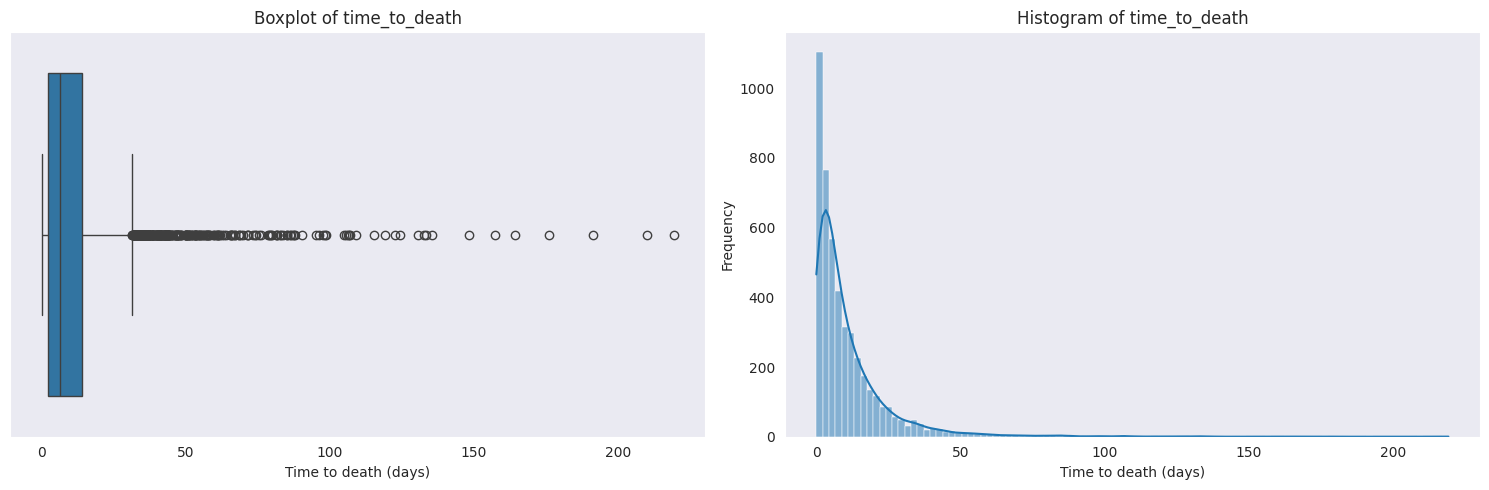

count    4728.000000
mean       11.019815
std        15.301403
min         0.000000
25%         2.325521
50%         6.280903
75%        13.944097
max       219.284028
Name: time_to_death, dtype: float64


In [13]:
# Let's check the target variable
# Plot a subplot of 1 row and 2 columns with historogram and boxplot


plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 2)
sns.histplot(df[target], kde=True, bins = 100)
plt.title("Histogram of time_to_death")
plt.xlabel("Time to death (days)")
plt.ylabel("Frequency")


plt.subplot(1, 2, 1)
sns.boxplot(x=df[target])
plt.title("Boxplot of time_to_death")
plt.xlabel("Time to death (days)")
plt.tight_layout()
plt.show()

print(df[target].describe())

### Insight:

## 3.2.a) Categorical Features:
Since we have a lot of numerical features let's first check the categorical features and visual them.

In [63]:
# Check for missing values in categorical columns
df[categorical_cols].isnull().mean().sort_values(ascending=False)

gender                                    0.0
race                                      0.0
insurance                                 0.0
admission_type                            0.0
admission_location                        0.0
discharge_location                        0.0
flag_history_CHF_ICD_CODES                0.0
flag_history_DIABETES_ICD_CODES           0.0
flag_history_CKD_ICD_CODES                0.0
flag_history_CANCER_ICD_CODES             0.0
flag_history_COPD_ICD_CODES               0.0
flag_history_LIVER_DISEASE_ICD_CODES      0.0
flag_history_MI_ICD_CODES                 0.0
flag_history_STROKE_ICD_CODES             0.0
flag_history_SEPSIS_ICD_CODES             0.0
flag_history_AKI_ICD_CODES                0.0
flag_chronic_anemia_prior                 0.0
flag_history_on_insulin                   0.0
flag_history_on_diuretics                 0.0
flag_history_on_anticoagulants            0.0
flag_history_on_steroids                  0.0
flag_history_on_chemotherapy      

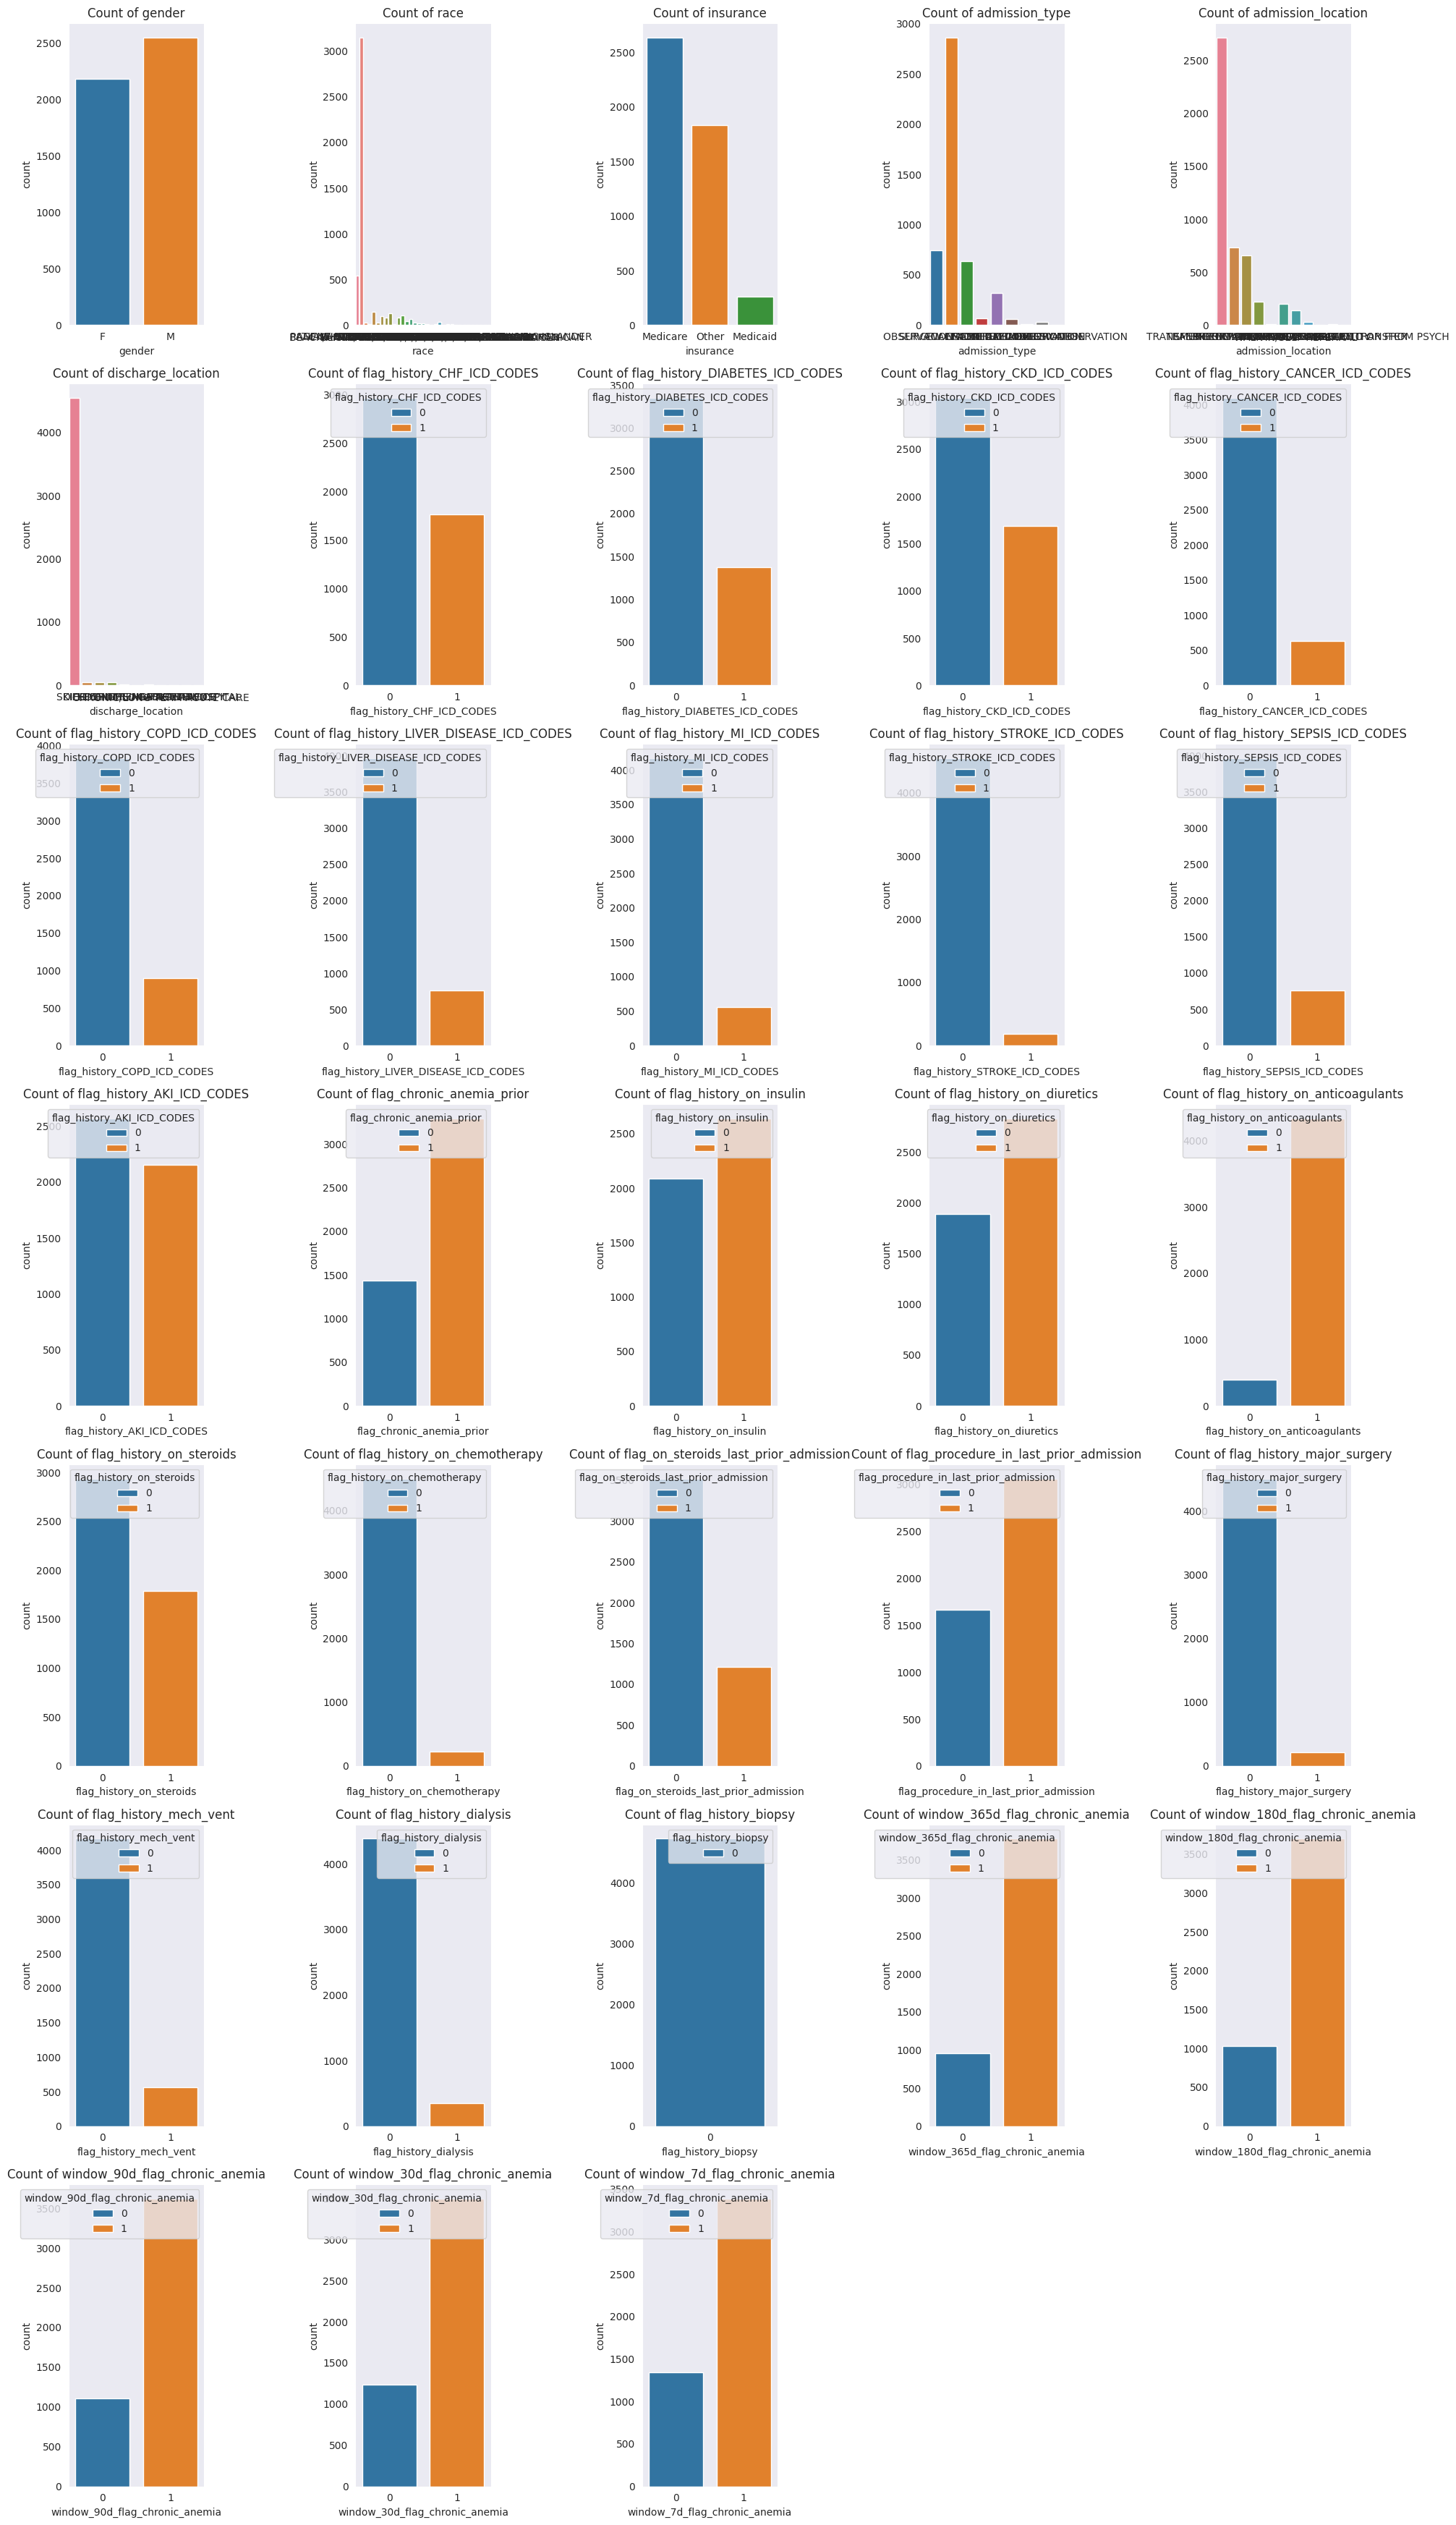

In [64]:
# Let's plot the categorical columns and view their value counts

# Plot categorical columns into subplots of 4 columns each
def plot_categorical_columns(df, categorical_cols):
    num_cols = 5
    num_rows = int(np.ceil(len(categorical_cols) / num_cols))
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    axes = axes.flatten()
    
    for i, col in enumerate(categorical_cols):
        sns.countplot(data=df, x=col, hue=col, ax=axes[i])
        axes[i].set_title(f"Count of {col}")
        # axes[i].tick_params(axis='x', rotation=90)
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

plot_categorical_columns(df, categorical_cols) 

### Insights:
1. The race is essentially ethnic background, and the majority of patients are white.
2. We will need to summarize the ethinic background into a few categories. like `White`, `Black`, `Asian`, `Hispanic`, `Other`. `Unknown` (which is 2%) and `Other` (which is 3%) can be combined into `Other`. We will preprocess this later.
3. Insurance is also a categorical variable, and we can see that the majority of patients are covered by Medicare. (55%)
4. Gender is fairly balanced, with a slight majority to the male side (54%).
5. `flag_history_biopsy` has zero variance. We can remove it.
6. The count for `flag_chronic_anemia` doesn't vary much in the different time window.
7. We can simply remove `discharge location` is it popultaed with "DIED"



**`TODO:`**
1. Write categorize_ethnicity to summarize the ethinicity
2. Encode the categories 
3. Remove `flag_history_biopsy`
4. Investigate `flag_chronic_anemia`

## 3.2.b) Numerical Features

We have a lot of them, lets categorize them from the origin:
- Diagnosis
- Labevents
- Prescription
- Procedure


In [93]:
df[numerical_cols].isnull().mean().sort_values(ascending=False)[:50]

time_since_first_diagnosis_STROKE_ICD_CODES_years           0.961717
time_since_last_major_surgery_years                         0.953680
time_since_first_diagnosis_MI_ICD_CODES_years               0.882614
time_since_first_diagnosis_CANCER_ICD_CODES_years           0.865905
time_since_first_diagnosis_LIVER_DISEASE_ICD_CODES_years    0.839467
time_since_first_diagnosis_SEPSIS_ICD_CODES_years           0.838621
time_since_first_diagnosis_COPD_ICD_CODES_years             0.810702
time_since_first_diagnosis_DIABETES_ICD_CODES_years         0.708122
time_since_first_diagnosis_CKD_ICD_CODES_years              0.643613
time_since_first_diagnosis_CHF_ICD_CODES_years              0.626692
time_since_first_diagnosis_AKI_ICD_CODES_years              0.543782
window_7d_albumin_max                                       0.179146
window_7d_albumin_min                                       0.179146
window_7d_albumin_avg                                       0.179146
window_7d_albumin_std             

In [94]:
# Categorize the numerical columns into their sources to deal with them easily
from assessment.config import DIAGNOSIS_ICD_COLUMNS

In [68]:
def plot_histograms(df, numerical_cols, columns, nrows=5, ncols=7):

    valid_cols = [col for col in columns if col in numerical_cols]
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
    for i, col in enumerate(valid_cols):
        ax = axes[i // ncols, i % ncols]
        sns.histplot(df[col], bins=30, kde=True, ax=ax)
        ax.set_title(col)
    for ax in axes.flat:
        ax.label_outer()
        ax.set_xlabel(ax.get_xlabel(), fontsize=8)
        ax.set_ylabel(ax.get_ylabel(), fontsize=8)
        ax.set_title(ax.get_title(), fontsize=8)
    plt.tight_layout()
    plt.show()


def plot_boxplots(df, numerical_cols, columns, nrows=5, ncols=7):

    valid_cols = [col for col in columns if col in numerical_cols]
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
    for i, col in enumerate(valid_cols):
        ax = axes[i // ncols, i % ncols]
        sns.boxplot(df[col], ax=ax, )
        ax.set_title(col)
    for ax in axes.flat:
        ax.label_outer()
        ax.set_xlabel(ax.get_xlabel(), fontsize=8)
        ax.set_ylabel(ax.get_ylabel(), fontsize=8)
        ax.set_title(ax.get_title(), fontsize=8)
    plt.tight_layout()
    plt.show()


def plot_scatterplots(df, numerical_cols, columns, nrows=5, ncols=7):

    valid_cols = [col for col in columns if col in numerical_cols]
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
    for i, col in enumerate(valid_cols):
        ax = axes[i // ncols, i % ncols]
        sns.scatterplot(x = df[col], y = df[target], ax=ax)
        ax.set_title(col)
    # use small font size for the title
    for ax in axes.flat:
        ax.label_outer()
        ax.set_xlabel(ax.get_xlabel(), fontsize=8)
        ax.set_ylabel(ax.get_ylabel(), fontsize=8)
        ax.set_title(ax.get_title(), fontsize=8)
    plt.tight_layout()
    plt.show()

### 3.2.b.1) Diagonsis Variables - Univariate 

In [20]:
len(DIAGNOSIS_ICD_COLUMNS)
print(f"Diagnosis ICD columns: {DIAGNOSIS_ICD_COLUMNS[:5]}...")

Diagnosis ICD columns: ['count_prior_admissions', 'count_unique_diagnoses_prior', 'avg_diagnoses_per_prior_admission', 'time_since_last_admission_days', 'admission_frequency_last_year']...


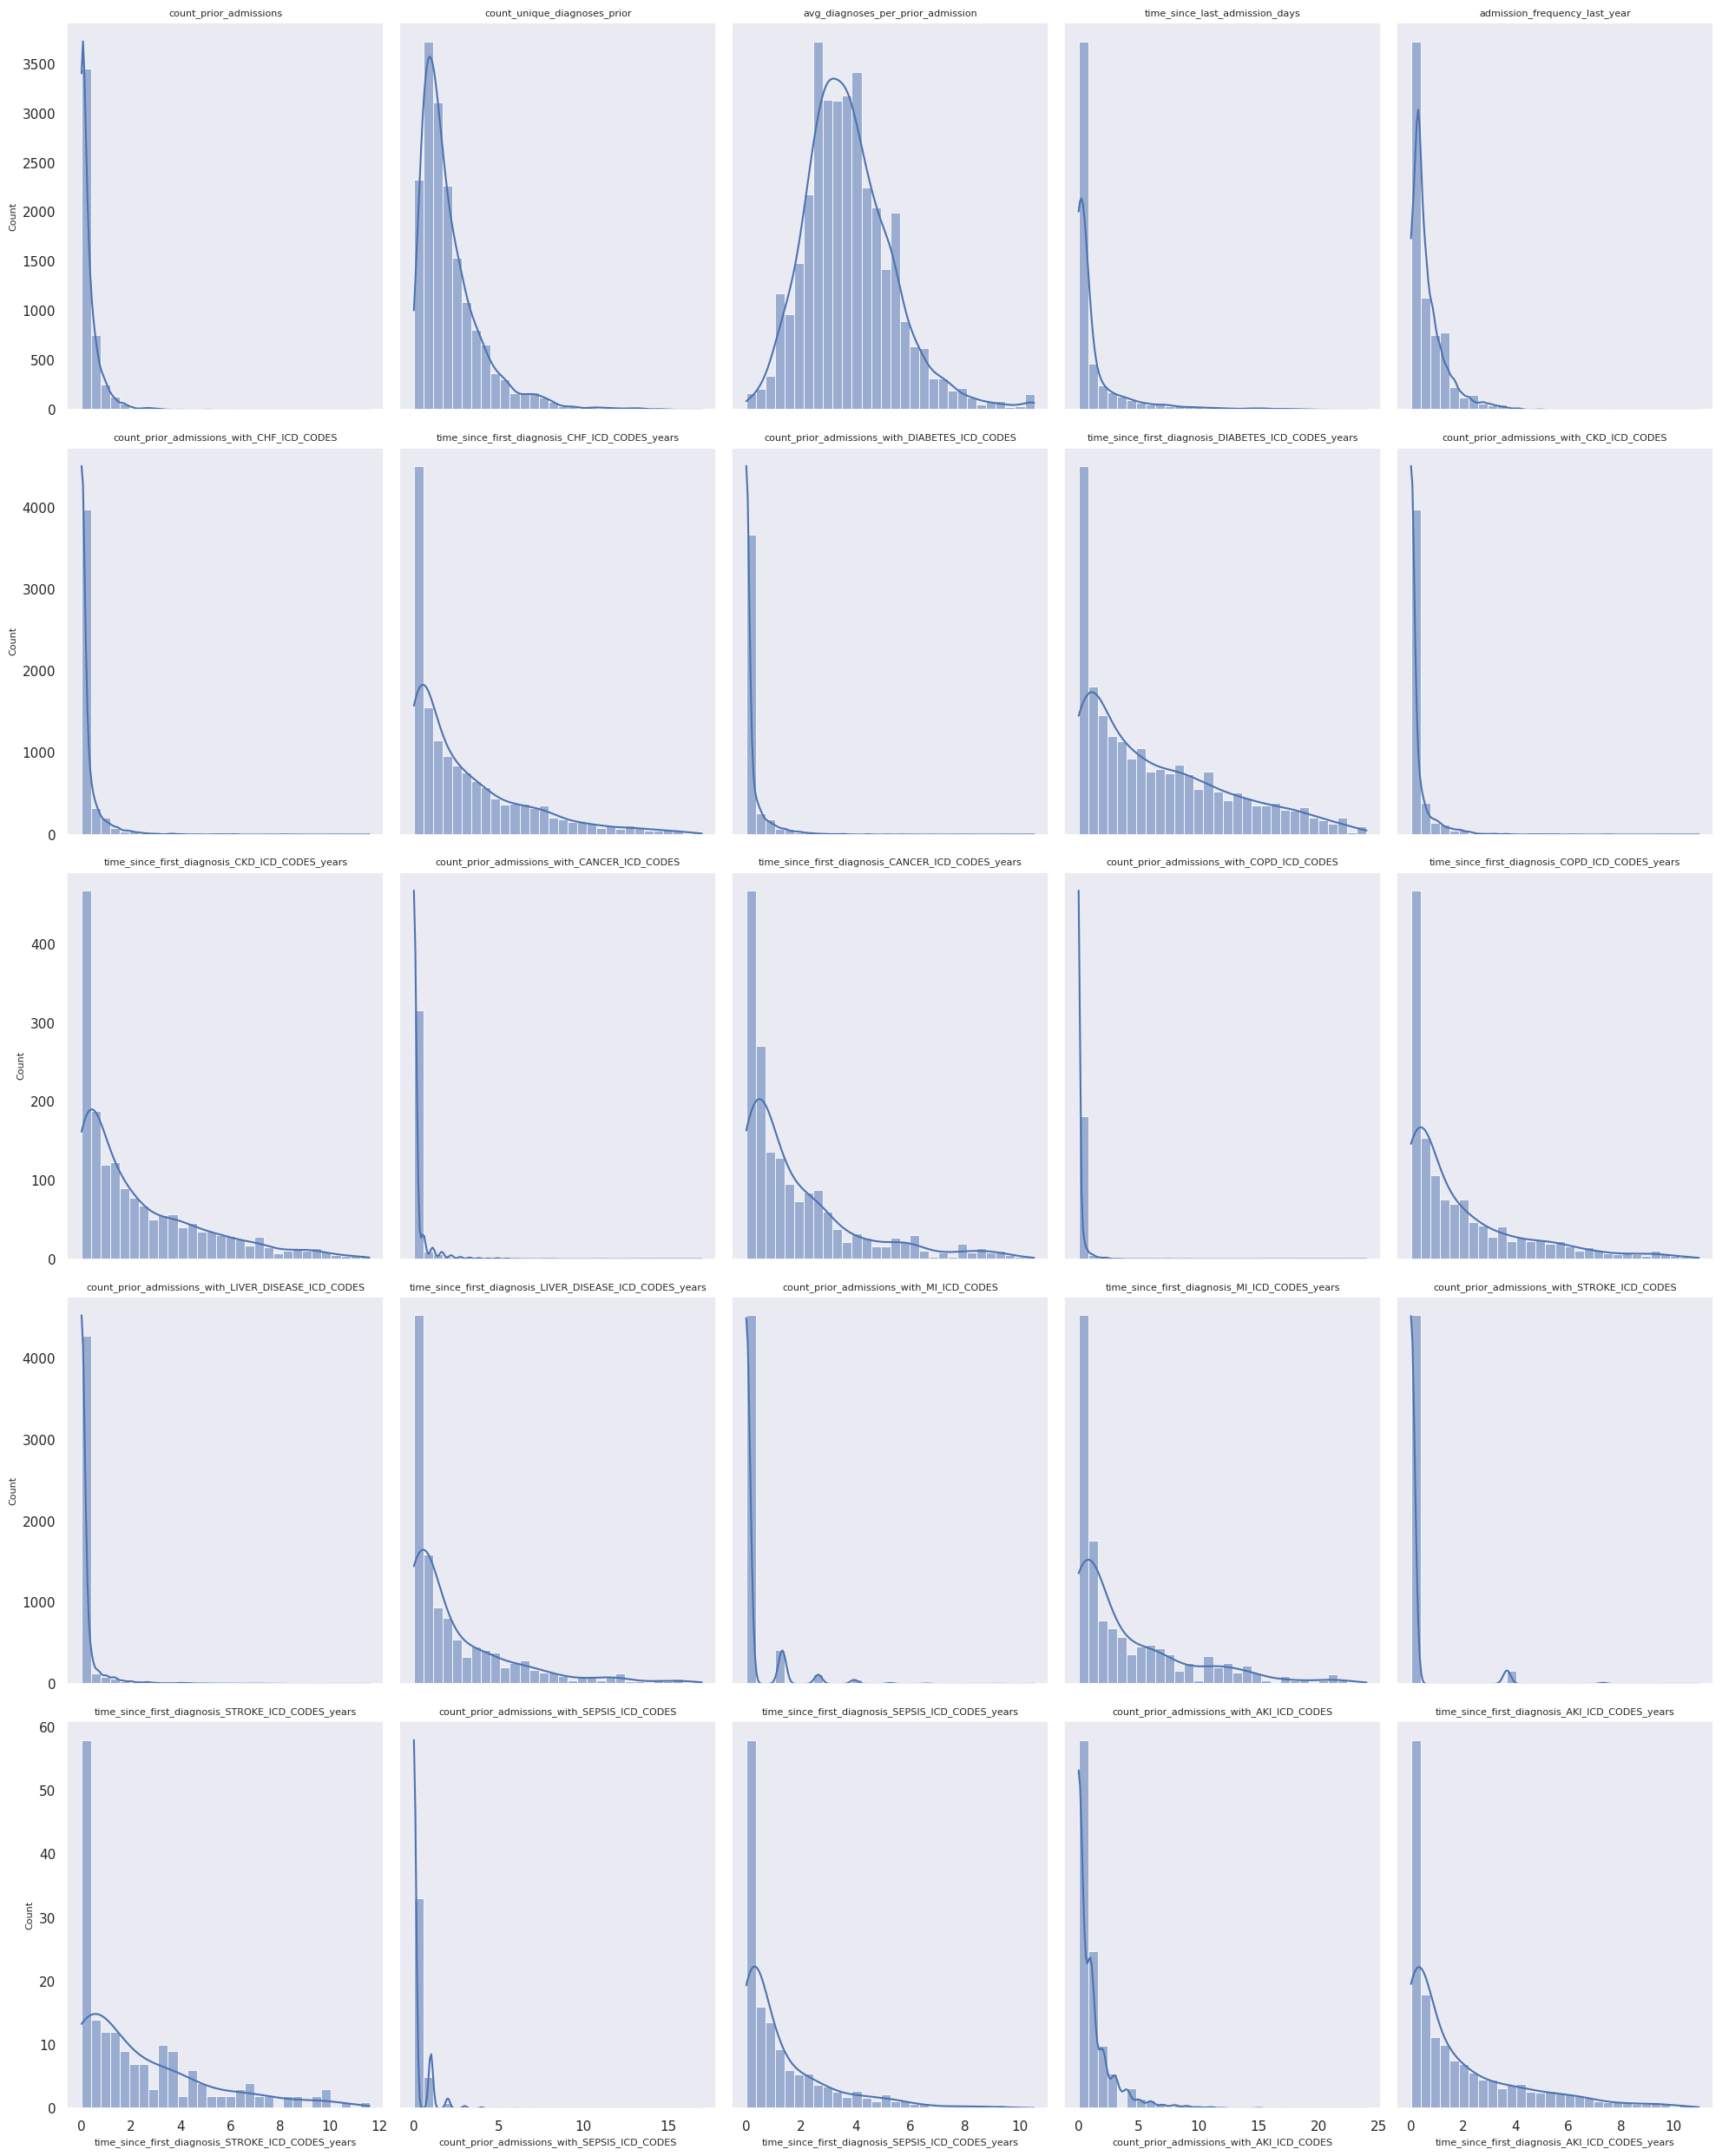

In [21]:
# Visualize histplot using subplots for DIAGNOSIS_ICD_COLUMNS first:
plot_histograms(df, numerical_cols, DIAGNOSIS_ICD_COLUMNS, nrows=5, ncols=5)

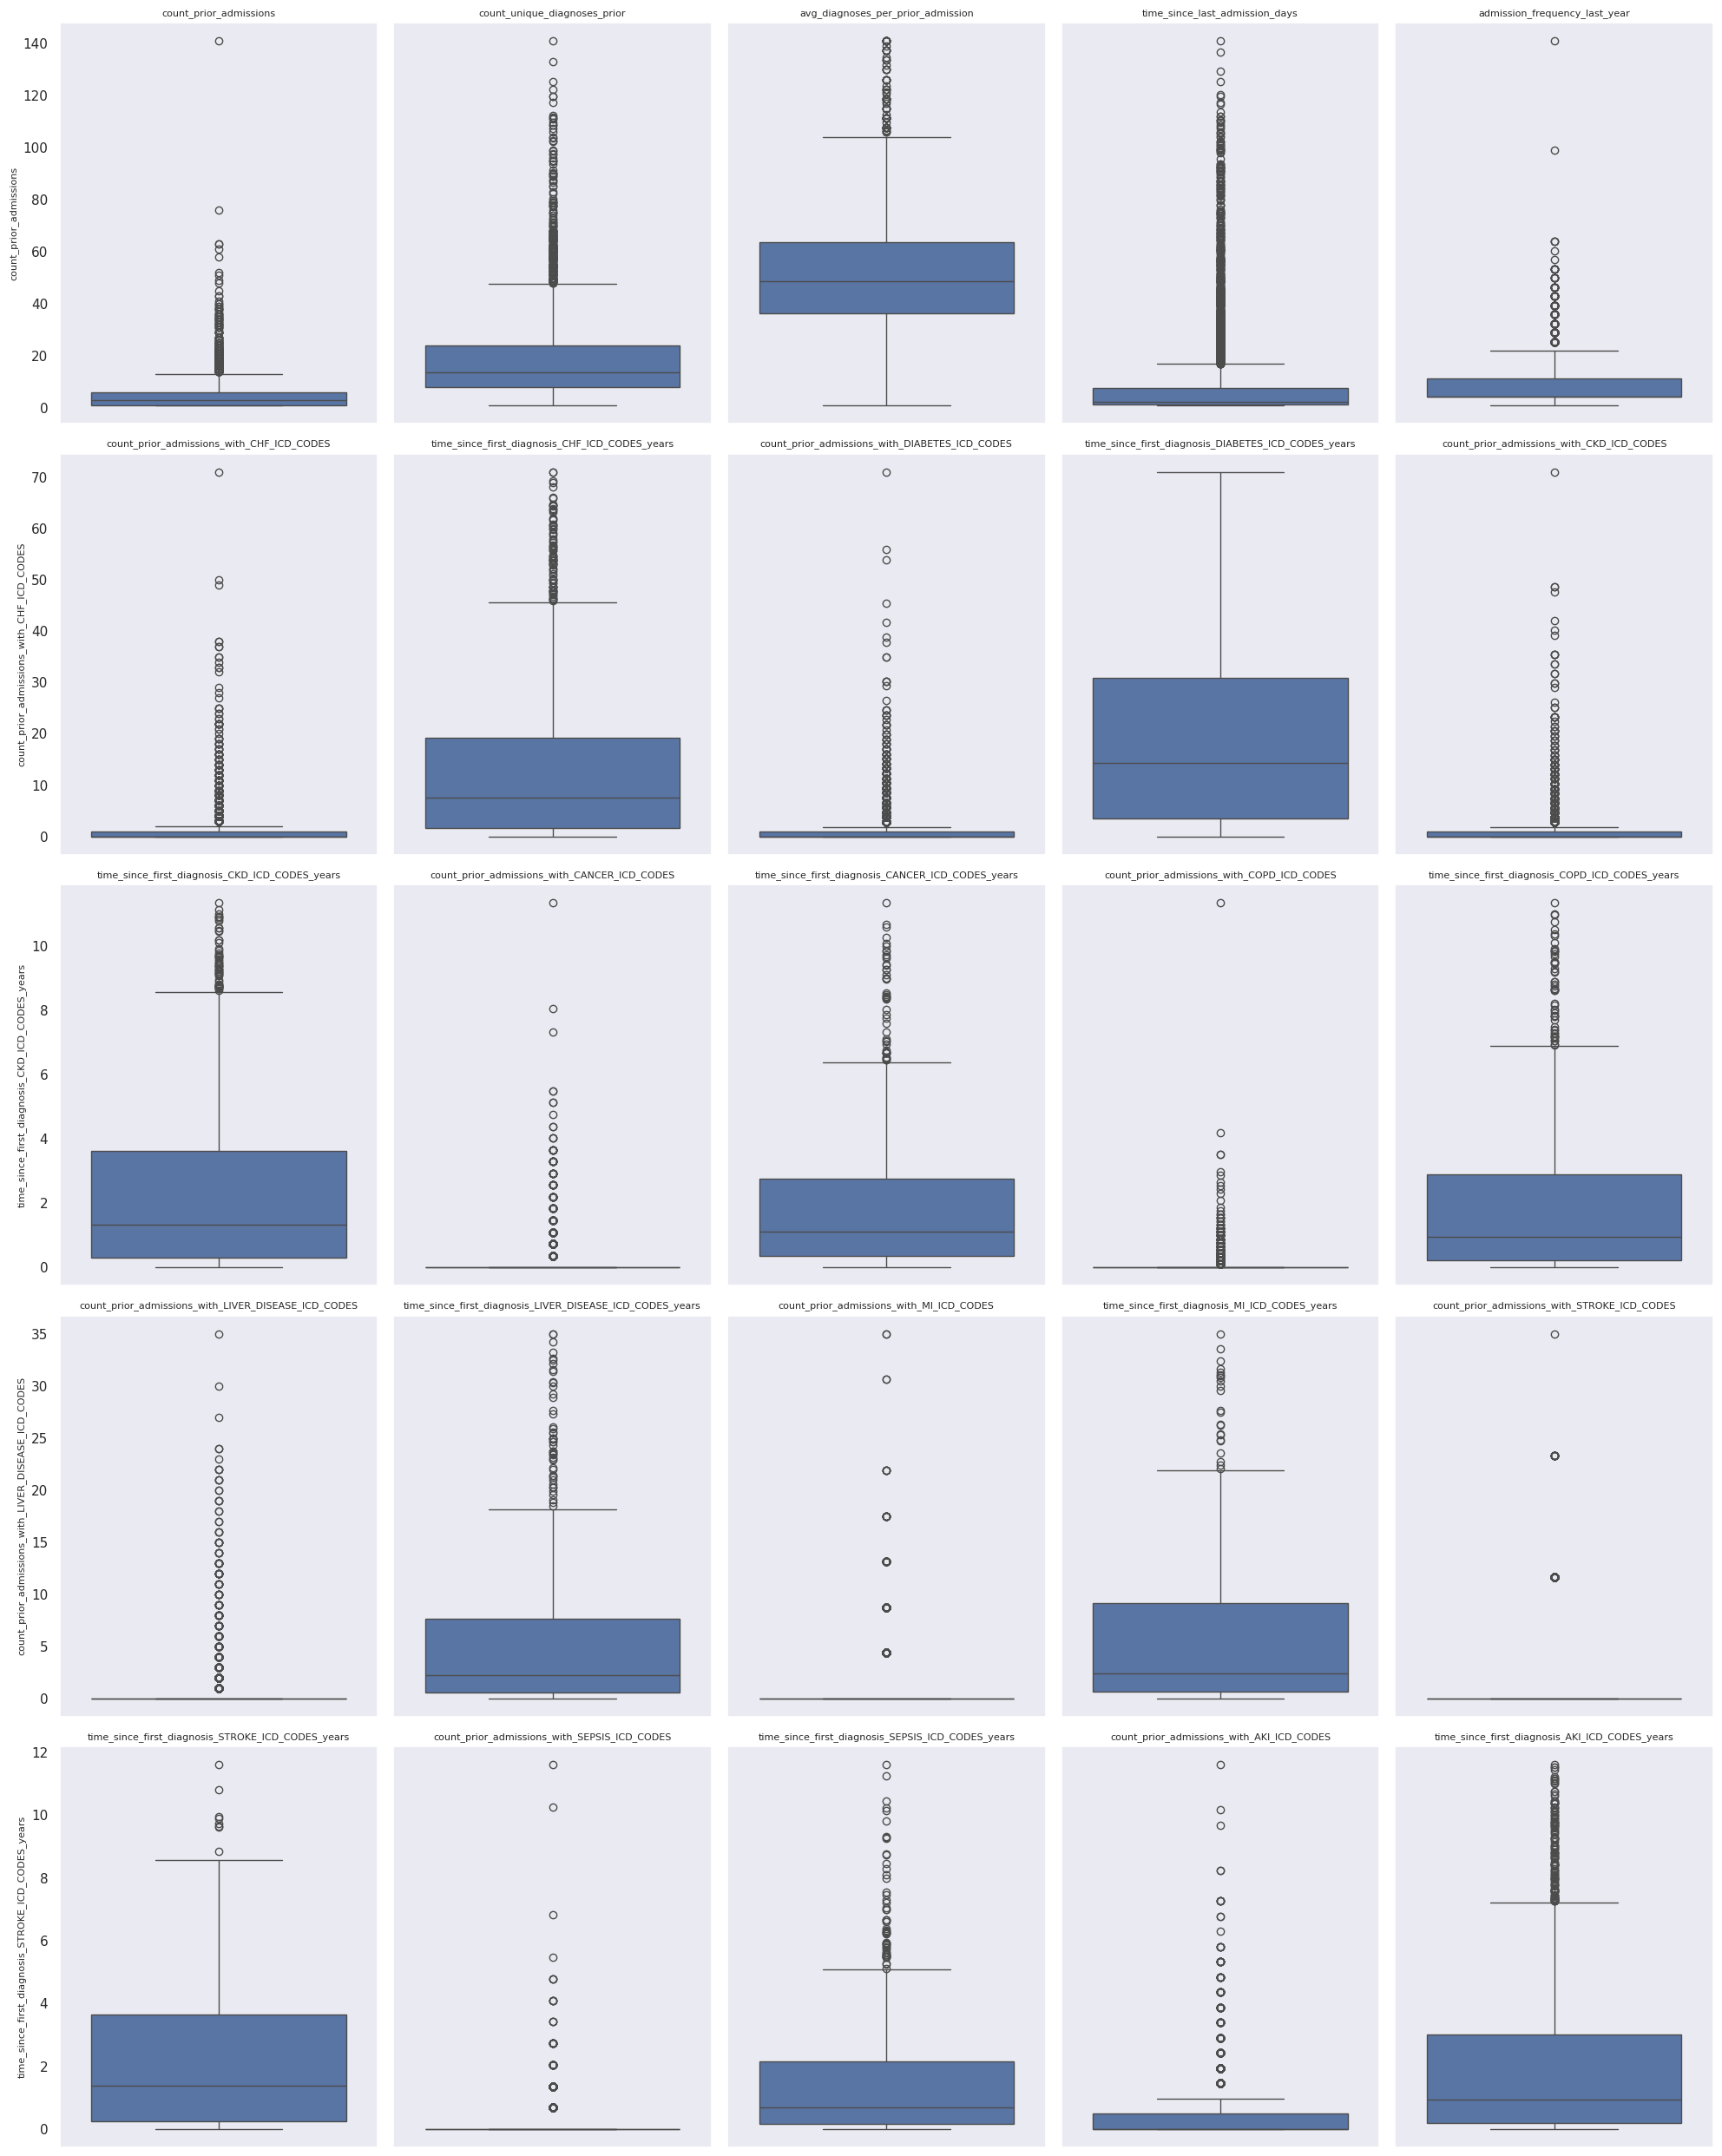

In [22]:
# Visualize boxplots using subplots for DIAGNOSIS_ICD_COLUMNS first:

plot_boxplots(df, numerical_cols, DIAGNOSIS_ICD_COLUMNS, nrows=5, ncols=5)

### Insights:
1. Most of the variables are heavily right-skewed. 
2. WE need to deal with outliers and We might need to apply log transformation or other transformations to normalize the data.
3. The only varible that appears normally distributed is `average_diagnosis_per_prior_admissions`

**`TODO`**
1. Deal with outliers.
2. Apply log transformation to the numerical_cols of diagonisis numerical col


### 3.2.b.2) Diagonsis Variables - Bivariate 

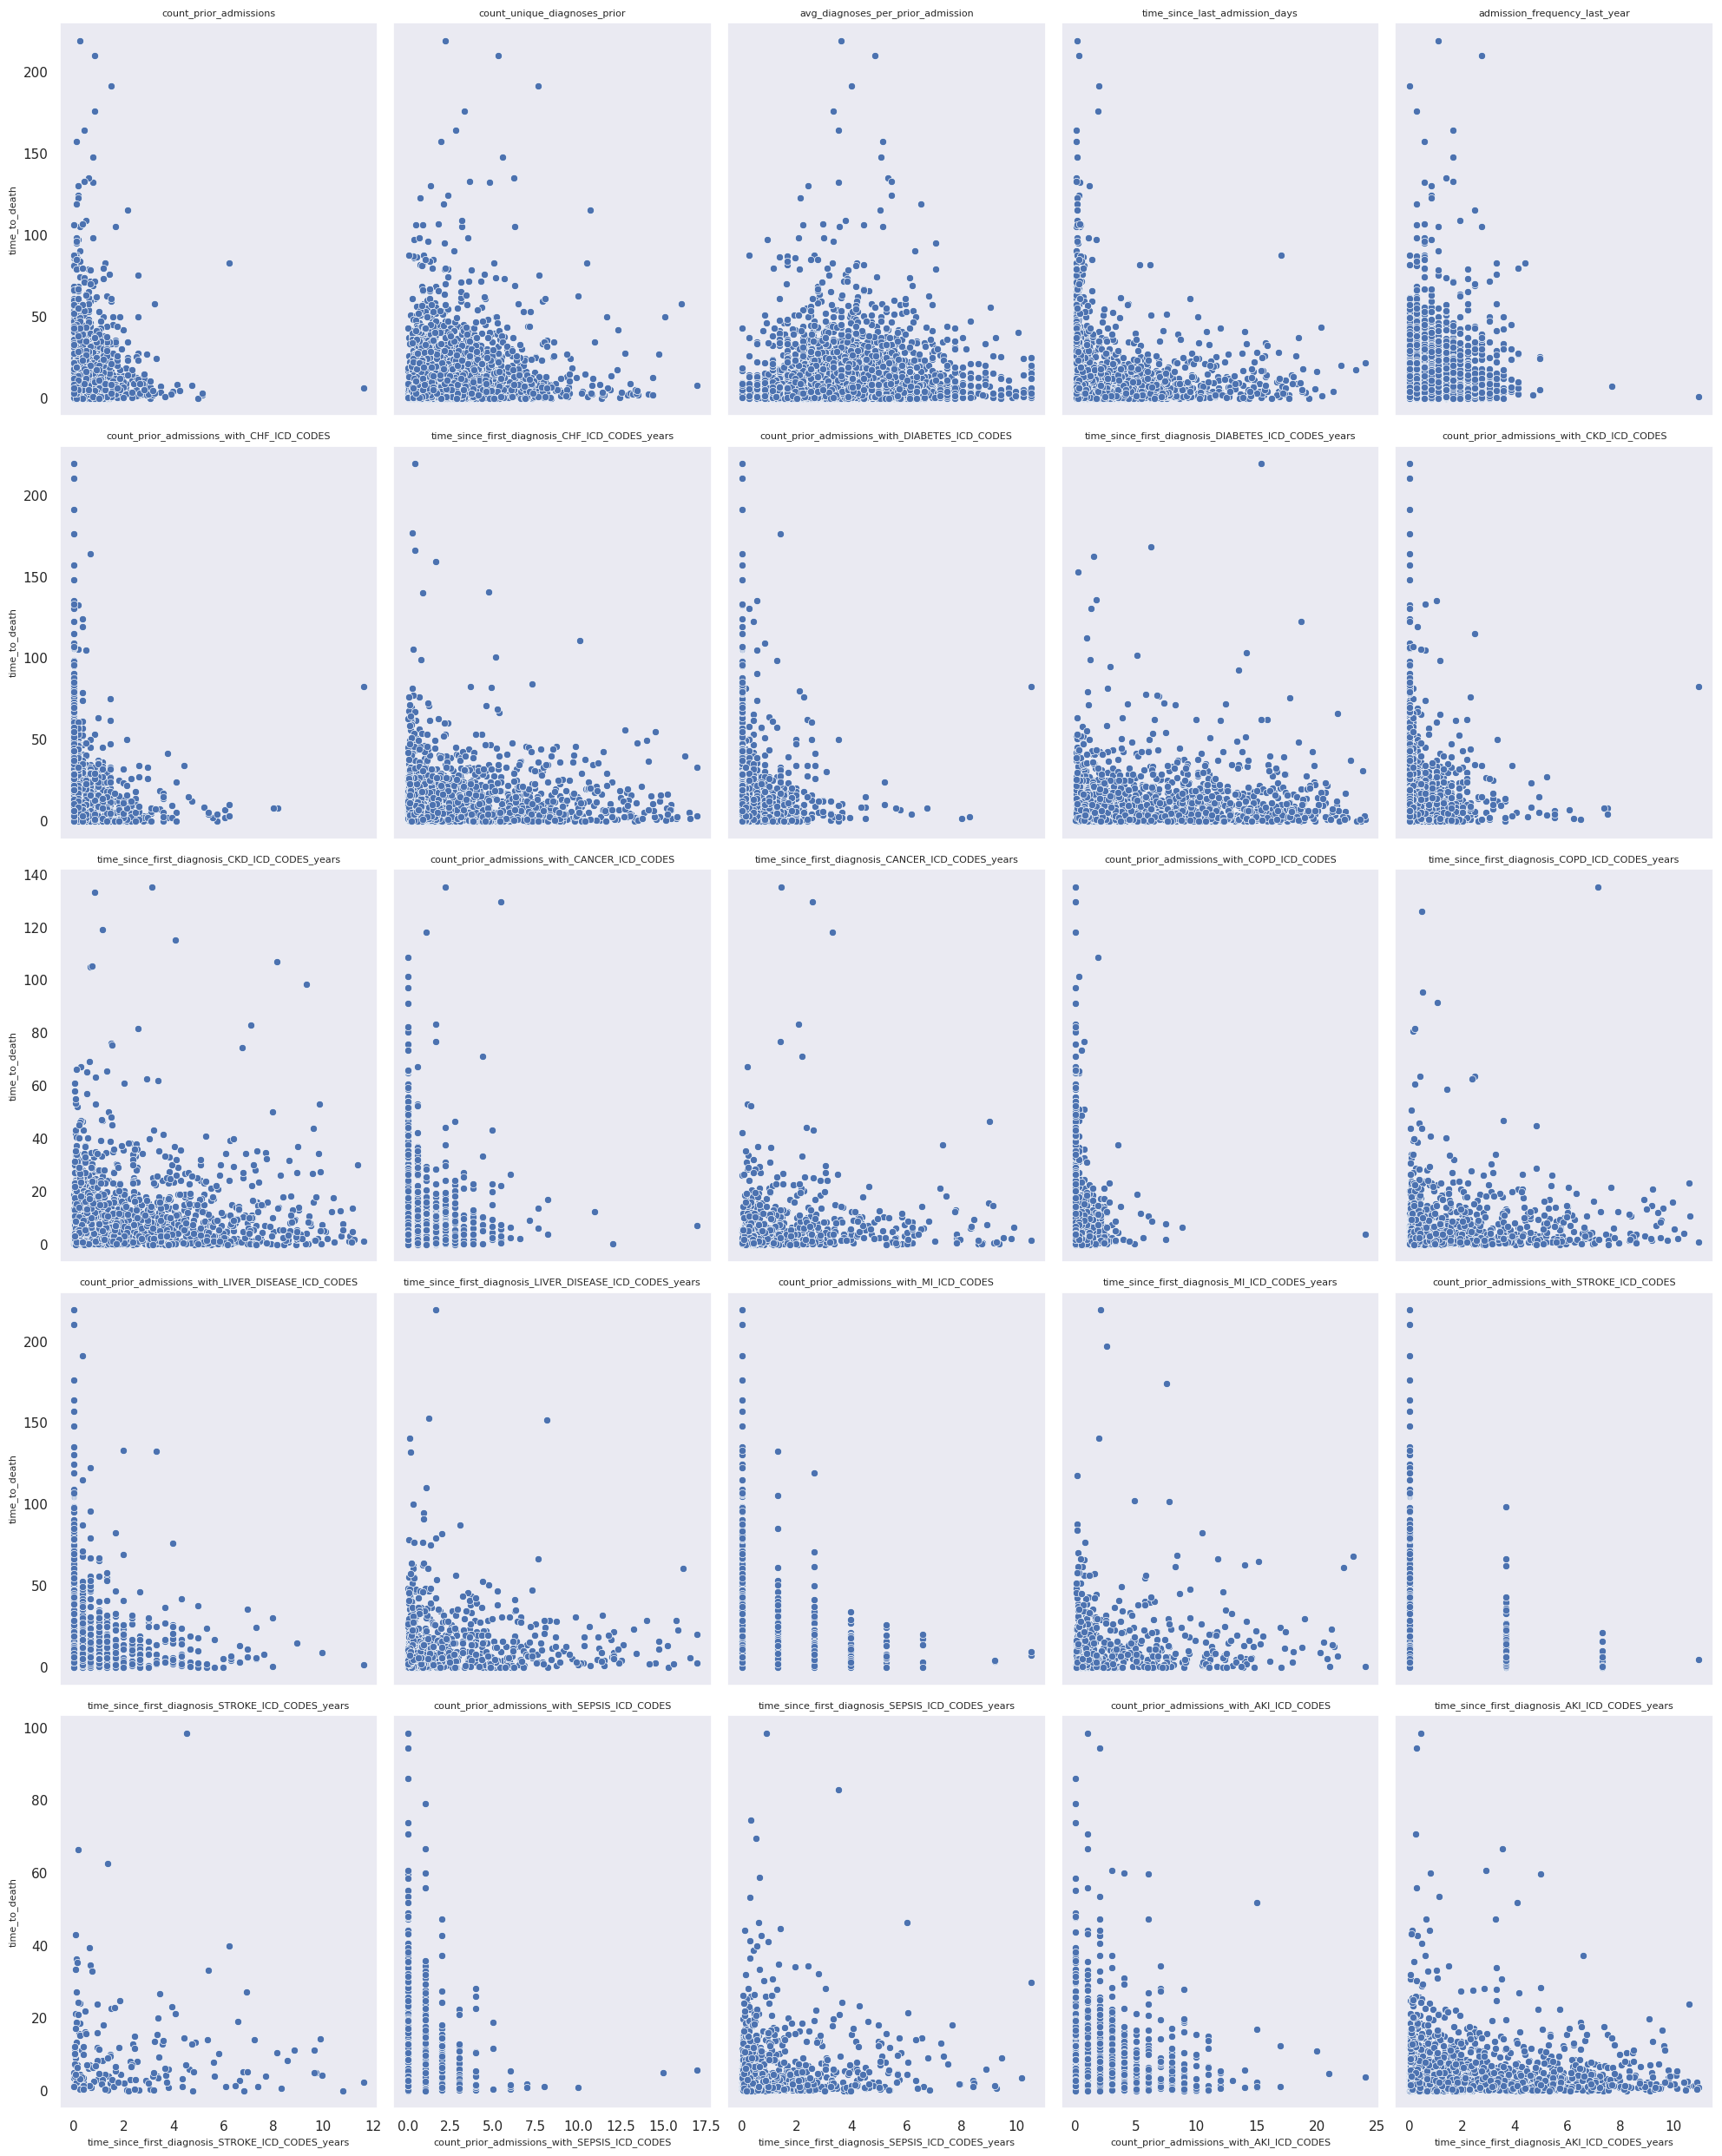

In [23]:
plot_scatterplots(df, numerical_cols, DIAGNOSIS_ICD_COLUMNS, nrows=5, ncols=5)

### 3.2.b.3) Multivariate - Correlation:

<Axes: >

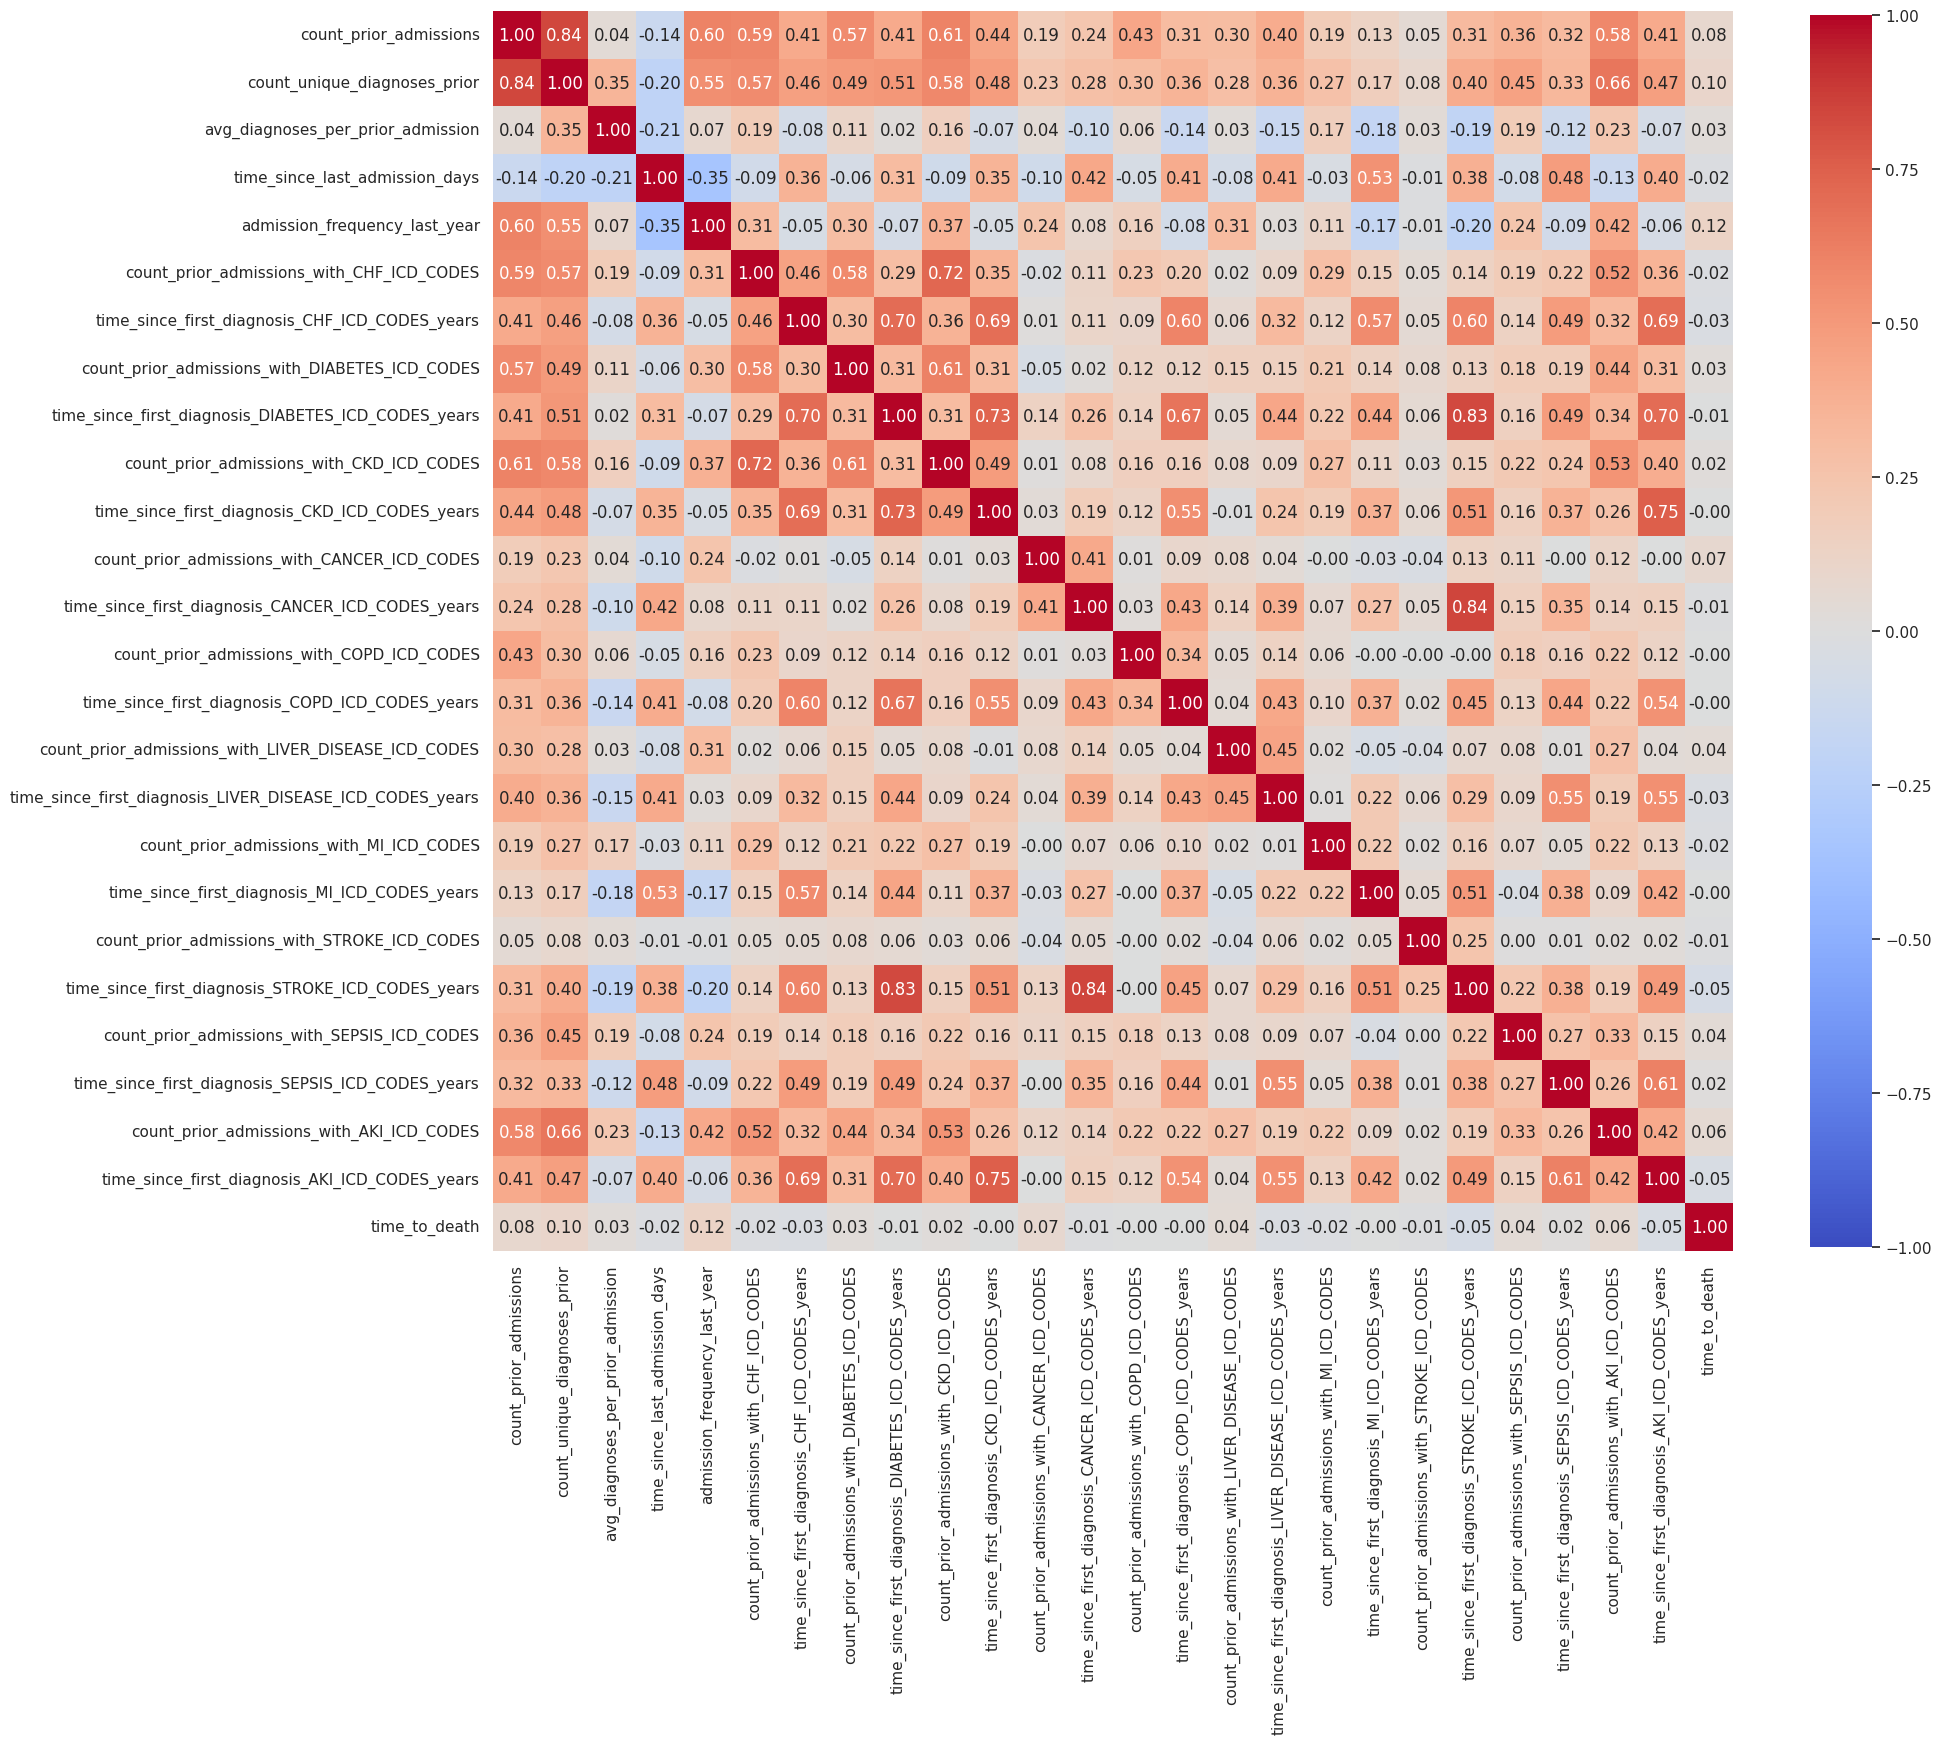

In [24]:
# Plot correlation matrix for DIAGNOSIS_ICD_COLUMNS heatmap
valid_cols = [col for col in DIAGNOSIS_ICD_COLUMNS if col in numerical_cols]
col = valid_cols + [target]

plt.figure(figsize=(20,20))
sns.heatmap(df[col].corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8}, vmax=1, vmin=-1)

### Insight:
1. Many features created have strong positive linear correlations
2. Most features don't have any linear correlationship with the labels


Similar EDA can be replicated for other Labevents, Prescription, Procedure...

## 3.3 Feature Preprocessing

Categorical:
- Ethinicity variable
- Admission type

Numerical:
- Imputing
- Outlier Removal - Winsorization


sklearn pipeline

In [40]:
from sklearn.model_selection import train_test_split

columns_to_remove.append(target)
X = df.drop(columns=columns_to_remove, errors="ignore")
y = df[target]

## 3.3.1 Categorical Features

In [41]:
# Function that changes the values of the column to the values in the mapping
def map_columns(df, old_column, new_column, mapping, is_categorical=True):
    df[new_column] = df[old_column].map(mapping)
    df.drop(columns=[old_column], inplace=True, errors='ignore')
    print(f"Mapping {old_column} to {new_column}")
    return df

In [42]:
# Reference: https://pmc.ncbi.nlm.nih.gov/articles/PMC10524813/#s1:~:text=of%20Stay%20Criteria.-,Asian,Demographics,-Age%2C%20years%2C%20median

from assessment.config import ETHNICITY_MAPPING

old_column = "race"
new_column = "grouped_ethnicity"
X = map_columns(X, "race", "grouped_ethnicity", ETHNICITY_MAPPING, is_categorical=True)
X["grouped_ethnicity"].value_counts(normalize=True)

categorical_cols.append(new_column)
categorical_cols.remove(old_column)

Mapping race to grouped_ethnicity


In [43]:
# Map: What are the meanings of different "admission type" values in MIMIC IV?  # 1215 https://github.com/MIT-LCP/mimic-code/discussions/1215


from assessment.config import ADMISSION_TYPE_MAPPING

old_column = "admission_type"
new_column = "grouped_admission_type"
display(X["admission_type"].value_counts(normalize=True))
X = map_columns(X, "admission_type", "grouped_admission_type", ADMISSION_TYPE_MAPPING, is_categorical=True)
display(X["grouped_admission_type"].value_counts(normalize=True))

categorical_cols.append(new_column)
categorical_cols.remove(old_column)

admission_type
EW EMER.                       0.604907
OBSERVATION ADMIT              0.157149
URGENT                         0.134306
DIRECT EMER.                   0.068316
SURGICAL SAME DAY ADMISSION    0.014382
ELECTIVE                       0.012479
EU OBSERVATION                 0.006768
DIRECT OBSERVATION             0.001481
AMBULATORY OBSERVATION         0.000212
Name: proportion, dtype: float64

Mapping admission_type to grouped_admission_type


grouped_admission_type
EMERGENCY    0.932013
ELECTIVE     0.067987
Name: proportion, dtype: float64

## 3.3.2 Numerical Features

Split train and test.
Fit on train, transform on test.

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
print(f"Shape of train:{X_train.shape}, Shape of test: {X_test.shape}")

Shape of train:(4018, 387), Shape of test: (710, 387)


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures, MinMaxScaler,FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def winsorization(X, perc = 2):
    lower, upper = np.percentile(X, perc) , np.percentile(X, 100 - perc)
    return np.clip(X, lower, upper)  



numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    # ('winsorization', FunctionTransformer(winsorization)),
    ('scaler', MinMaxScaler()),

])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output= False, drop = "first", handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('nom', nominal_transformer, categorical_cols),
    ],
    remainder='passthrough'
).set_output(transform="pandas")

In [67]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
X_train_processed.shape, X_test_processed.shape

((4018, 390), (710, 390))

In [91]:
# Save the data for the next step
from assessment.config import PROCESSED_DATA_DIR

X_train_processed.to_csv(PROCESSED_DATA_DIR / "X_train_processed.csv", index=False)
X_test_processed.to_csv(PROCESSED_DATA_DIR / "X_test_processed.csv", index=False)
y_train.to_csv(PROCESSED_DATA_DIR / "y_train.csv", index=False)
y_test.to_csv(PROCESSED_DATA_DIR / "y_test.csv", index=False)

In [68]:
# Create new columns after transformation

numerical_cols_2 = [col for col in X_train_processed.columns if col.startswith("num")]
categorical_cols_2 = [col for col in X_train_processed.columns if col.startswith("nom")]

print(f"Numerical columns: {len(numerical_cols_2)}")
print(f"Categorical columns: {len(categorical_cols_2)}")

Numerical columns: 356
Categorical columns: 34


In [69]:
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA



num_transf = ColumnTransformer([
    ("square", FunctionTransformer(func = np.square), numerical_cols_2),
    ("log_trans", FunctionTransformer(func = np.log1p), numerical_cols_2),
    ("pca", PCA(n_components=2), numerical_cols_2)
], remainder="passthrough").set_output(transform="pandas")


# Subtask 4: Modelling Approaches
Implement different models. Explain and justify your modelling approach. . Modelling

## 4. Modelling

In [70]:
# Modeling pipeline

from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

import joblib

from assessment.config import MODELS_DIR

In [93]:
models = {
    "dummy" : DummyRegressor(),
    "lr" : LinearRegression(),
    "hub" : HuberRegressor(max_iter=3000,),
    "rf" : RandomForestRegressor(max_depth=5),
    "xgboost" : XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.1),
    "hist" : HistGradientBoostingRegressor(max_depth=5, learning_rate=0.1),
}

fitted_pipelines = {}

estimator = DecisionTreeRegressor(random_state=42, max_depth=5)

for name, model in models.items():
    print("="*20, name, "="*20)

    full_pipeline = Pipeline([
        ("trans", num_transf),
        ("selection", SelectFromModel(estimator, max_features=int(np.sqrt(X_train_processed.shape[0])))),
        ("model", model)
    ]).set_output(transform="pandas")


    cv_scores = cross_val_score(full_pipeline, X_train_processed, y_train, cv = 10, scoring="neg_mean_squared_error")
    print(cv_scores, np.mean(cv_scores), np.std(cv_scores))


    # Fully train the pipeline


    full_pipeline.fit(X_train_processed,y_train)
    y_pred = full_pipeline.predict(X_test_processed)

    mse = mean_squared_error(y_test,y_pred)
    r2 = r2_score(y_test, y_pred)

    print("MSE: ", mse)
    print("R2:", r2)

    # Save pipeline
    fitted_pipelines[name] = full_pipeline
    pipeline_name = MODELS_DIR / f"{name}_pipeline.pkl"
    # joblib.dump(full_pipeline, pipeline_name)

==================== dummy ====================
[-201.87602315 -294.05624622 -296.04294998 -202.88880006 -217.57741385
 -296.82824906 -226.6576853  -215.54506735 -147.8162254  -273.3908028 ] -237.26794631822457 47.89572523965506
MSE:  216.13487327787507
R2: -0.00019273320710211372
==================== lr ====================
[-48.46291424 -32.32685611 -44.33698073 -39.67524218 -62.84236361
 -65.41995164 -52.04317919 -37.46891748 -34.71296764 -37.6831473 ] -45.49725201105546 10.954121167133541
MSE:  44.15551194592653
R2: 0.795664524148422
==================== hub ====================
[-49.54681786 -34.17177326 -47.2417681  -41.54840777 -62.08922943
 -69.81278479 -53.26307479 -39.13963484 -34.60389537 -38.20218166] -46.96195678758404 11.318118120757074
MSE:  46.32029466042896
R2: 0.7856467056114108
==================== rf ====================
[-57.60039566 -27.39581371 -57.64133675 -33.23404309 -53.20855819
 -46.99403017 -45.05895105 -35.57571703 -27.42131013 -45.58794232] -42.9718098096

## Insights:
1. Best model is `XGBoost` with a MSE = 29.43, R2 = 0.863

In [ ]:
# Save fitted_pipelines
# for name, pipeline in fitted_pipelines.items():
#     joblib.dump(pipeline, MODELS_DIR / f"{name}_pipeline.pkl")

In [143]:
# Load from saved fitted_pipelines

fitted_pipelines = {}
for name in models.keys():
    if name == "dummy":
        continue
    pipeline_name = MODELS_DIR / f"{name}_pipeline.pkl"
    fitted_pipelines[name] = joblib.load(pipeline_name)

# Task 3: Performance & Explainability Analysis 

1. Evaluate your models using appropriate metrics (AUC, precision, recall, F1, or concordance index). 
2. Provide confusion matrices and stratified performance analysis (e.g., by age, 
gender). 
3. Apply model interpretability methods such as SHAP to explain predictions. 
4. Bonus: Compare your results across hospital and ICU cohorts or investigate the 
different causes of death. 


# Subtask 1: Evaluate your models using appropriate metrics
We choose MSE and R2 as our primary metrics for regression task


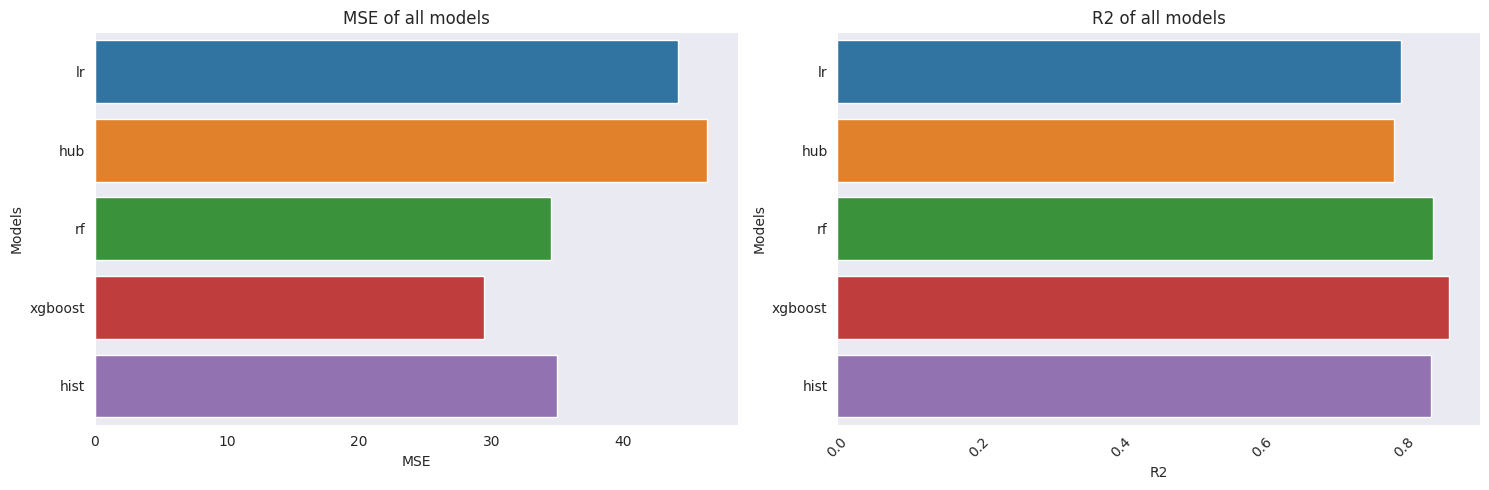

In [130]:
# Using full pipeline, plot MSE and R2 for all models
def plot_model_performance(fitted_pipelines, X_train, y_train, X_test, y_test):
    mse_list = []
    r2_list = []
    names = []
    for name, pipeline in fitted_pipelines.items():
        if name == "dummy":
            continue
        y_pred = pipeline.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mse_list.append(mse)
        r2_list.append(r2)
        names.append(name)
        
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.barplot(y=names, x=mse_list, hue = names, ax=ax[0])
    ax[0].set_title("MSE of all models")
    ax[0].set_ylabel("Models")
    ax[0].set_xlabel("MSE")
    sns.barplot(y=names, x=r2_list, hue = names, ax=ax[1])
    ax[1].set_title("R2 of all models")
    ax[1].set_ylabel("Models")
    ax[1].set_xlabel("R2")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_model_performance(fitted_pipelines, X_train_processed, y_train, X_test_processed, y_test)


## Subtask 1B & 2: Discretize the regression output & classification-style analysis: 
Based on: (AUC, precision, recall, F1, or concordance index)

Classification style question: _"Did the model correctly predict that this patient would die within X days?"_


Threshold: 3


Model       AUC  Precision    Recall        F1
0       rf  0.919824   0.859155  0.580952  0.693182
1  xgboost  0.923490   0.840278  0.576190  0.683616
2     hist  0.925700   0.830986  0.561905  0.670455

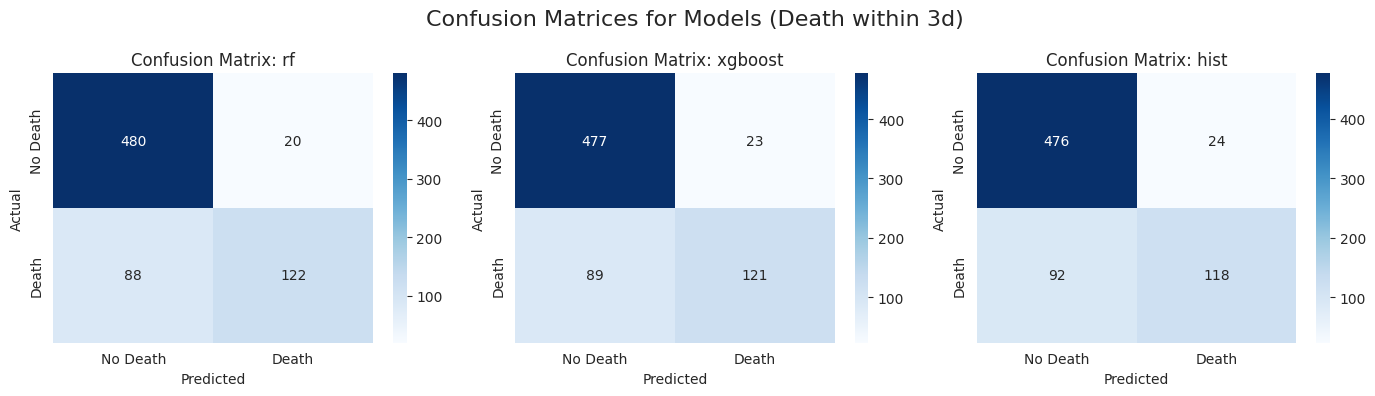

Threshold: 7


Model       AUC  Precision    Recall        F1
0       rf  0.937922   0.872973  0.863636  0.868280
1  xgboost  0.937663   0.870466  0.898396  0.884211
2     hist  0.942398   0.874016  0.890374  0.882119

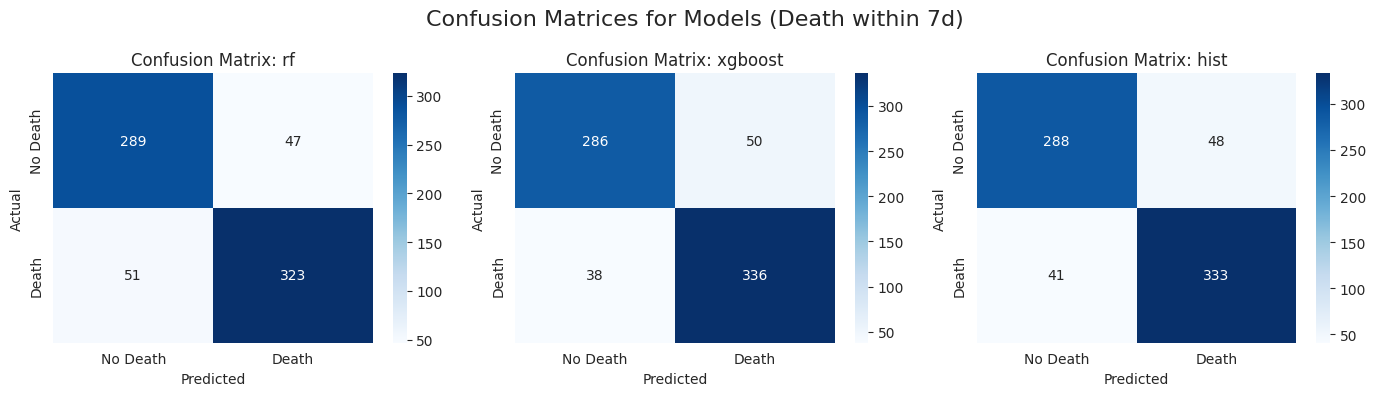

Threshold: 14


Model       AUC  Precision    Recall        F1
0       rf  0.963490   0.942164  0.931734  0.936920
1  xgboost  0.971106   0.948960  0.926199  0.937442
2     hist  0.971117   0.947170  0.926199  0.936567

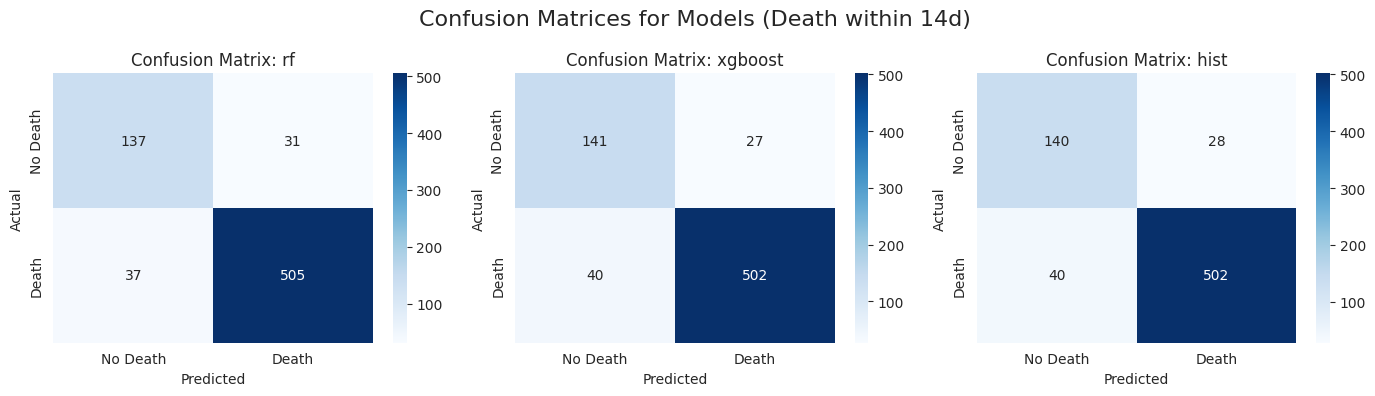

Threshold: 30


Model       AUC  Precision    Recall        F1
0       rf  0.978519   0.974513  0.989346  0.981873
1  xgboost  0.983487   0.975940  0.987823  0.981846
2     hist  0.984435   0.975976  0.989346  0.982615

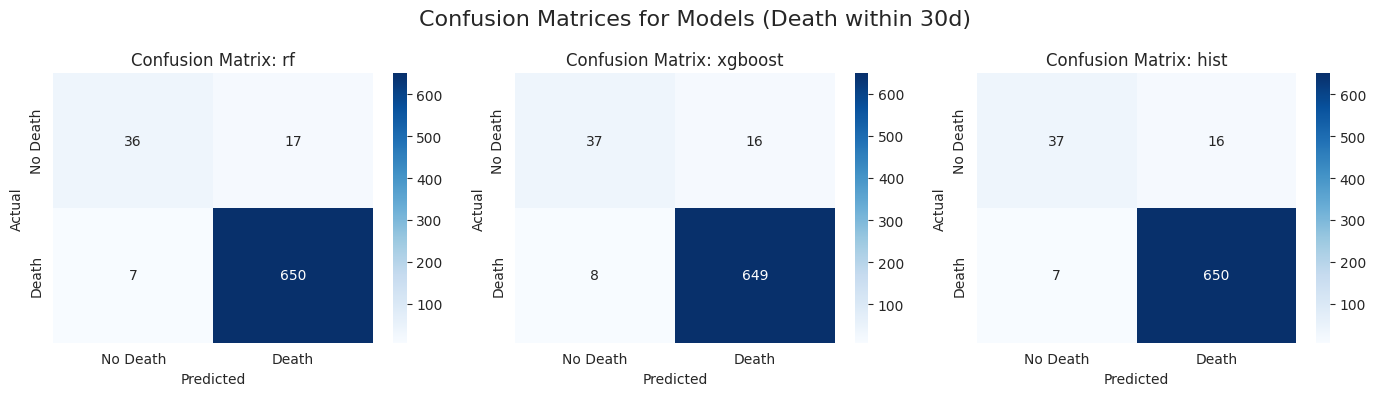

In [ ]:
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
)
def evaluate_models_clf_style(fitted_pipelines, X_train_processed, y_train, X_test, y_test, threshold=30):
    results = []

    for name, pipeline in fitted_pipelines.items():
        if name in ["dummy", "lr", "hub", ]:
            continue
        y_pred = pipeline.predict(X_test)
        y_true = y_test

        # Create binary labels: 1 = death within X days
        y_clf_true = (y_true <= threshold).astype(int)
        y_clf_pred = (y_pred <= threshold).astype(int)

        # Compute classification metrics
        auc = roc_auc_score(y_clf_true, y_pred * -1)  # Reverse because lower pred = higher death risk
        precision = precision_score(y_clf_true, y_clf_pred, zero_division=0)
        recall = recall_score(y_clf_true, y_clf_pred, zero_division=0)
        f1 = f1_score(y_clf_true, y_clf_pred, zero_division=0)
        cm = confusion_matrix(y_clf_true, y_clf_pred)

        results.append({
            'Model': name,
            'AUC': auc,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'Confusion Matrix': cm
        })

    # Convert to dataframe
    results_df = pd.DataFrame(results).drop(columns='Confusion Matrix')
    display(results_df)

    # Plot subplots for confusion matrix
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    for i, result in enumerate(results):
        sns.heatmap(result['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[i], xticklabels=['No Death', 'Death'], yticklabels=['No Death', 'Death'])
        axes[i].set_title(f'Confusion Matrix: {result["Model"]}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
    
    plt.suptitle(f'Confusion Matrices for Models (Death within {threshold}d)', fontsize=16)
    plt.tight_layout()
    plt.show()

for threshold in [3, 7, 14, 30]:
    print(f"Threshold: {threshold}")
    evaluate_models_clf_style(fitted_pipelines, X_train_processed, y_train, X_test_processed, y_test, threshold=threshold)

# Subtask 3: Model Interpretability
Apply model interpretability methods such as SHAP to explain predictions. 

In this section, we will apply feature importance first and then apply SHAP

<Axes: xlabel='importance', ylabel='features'>

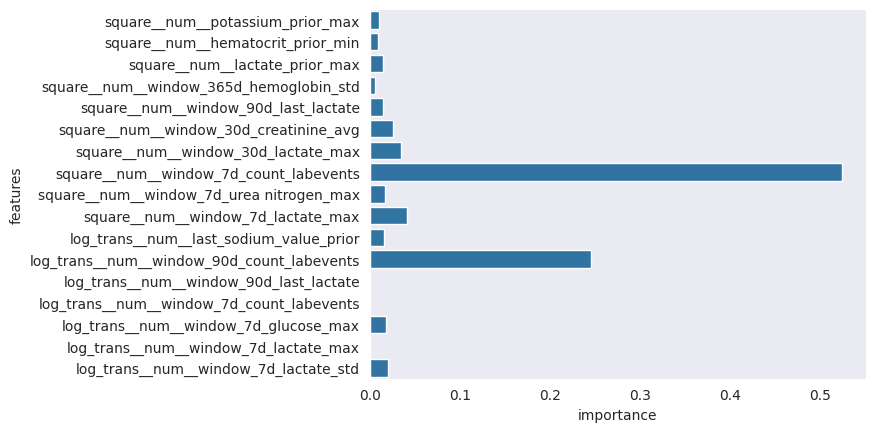

In [145]:
# Feature importance explaination

X_train_transformed = fitted_pipelines["xgboost"][:-1].transform(X_train_processed)
feat_importance = pd.DataFrame(data={
    "features" : X_train_transformed.columns,
    "importance" : fitted_pipelines["xgboost"]["model"].feature_importances_
})

sns.barplot(data = feat_importance, y = "features", x = "importance", orient="h")


## Insights:



## SHAP
We use our best model `XGBoost`

In [124]:
import shap

In [146]:
best_model = fitted_pipelines["xgboost"]["model"]
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [150]:
explainer = shap.TreeExplainer(model)
final_X_test = fitted_pipelines["xgboost"][:-1].transform(X_test_processed)
shap_values = explainer.shap_values(final_X_test)

Generating SHAP Summary Plot (Bar)...


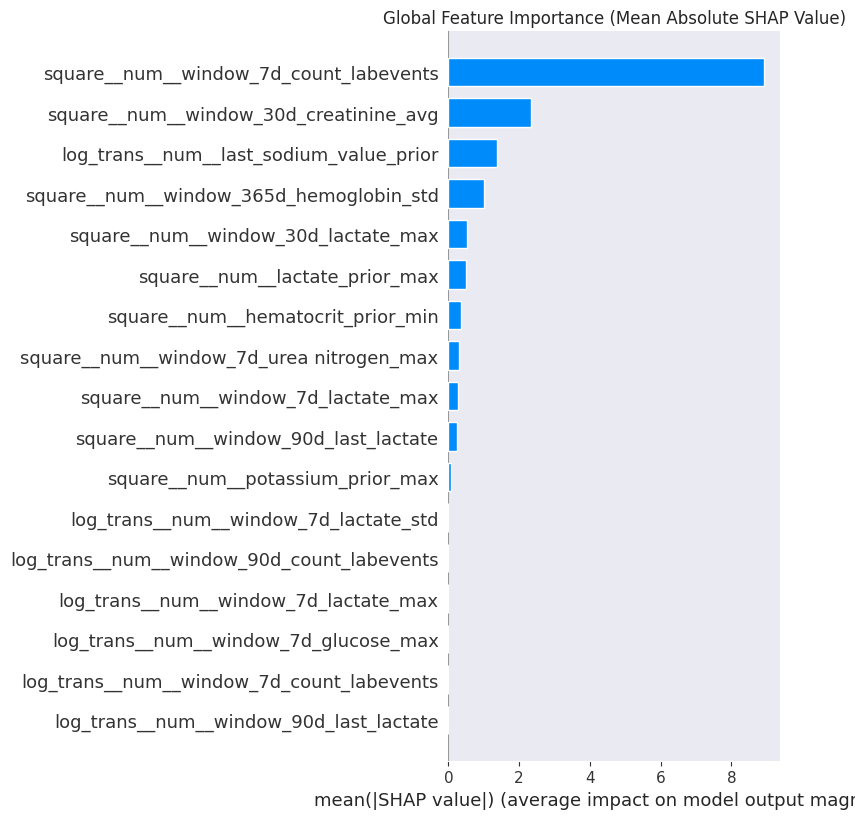

In [151]:
# Global Feature Importance: Summary Plot (Bar)
print("Generating SHAP Summary Plot (Bar)...")
plt.figure()
shap.summary_plot(shap_values, final_X_test, plot_type="bar", show=False)
plt.title("Global Feature Importance (Mean Absolute SHAP Value)")
plt.tight_layout()
plt.show()


Generating SHAP Summary Plot (Dot)...


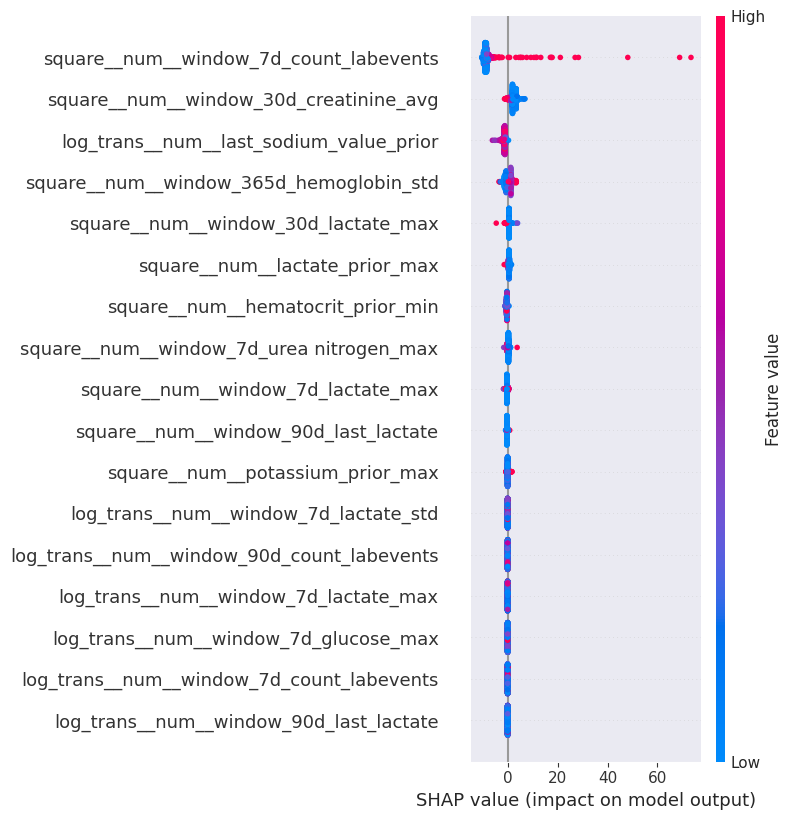

In [153]:
# 4. Global Feature Importance & Effect: Summary Plot (Dot/Violin)
#    Shows distribution and relationship with feature value. More informative.
print("Generating SHAP Summary Plot (Dot)...")
plt.figure()
shap.summary_plot(shap_values, final_X_test, show=False)
# Title is often automatically generated by shap.summary_plot
# plt.title("Feature Importance and Effect (SHAP Summary)")
plt.tight_layout()
plt.show()


Generating SHAP Dependence Plots for top features...


<Figure size 640x480 with 0 Axes>

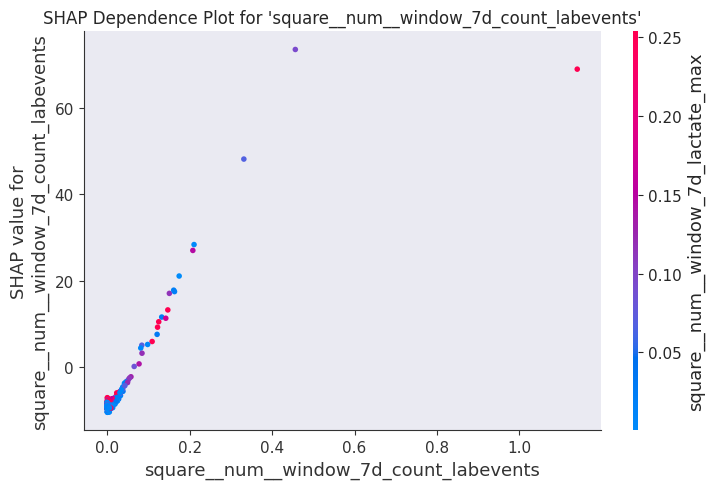

<Figure size 640x480 with 0 Axes>

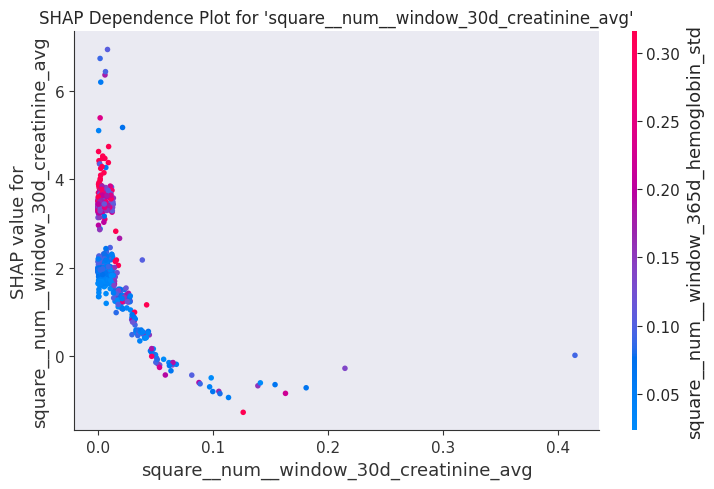

<Figure size 640x480 with 0 Axes>

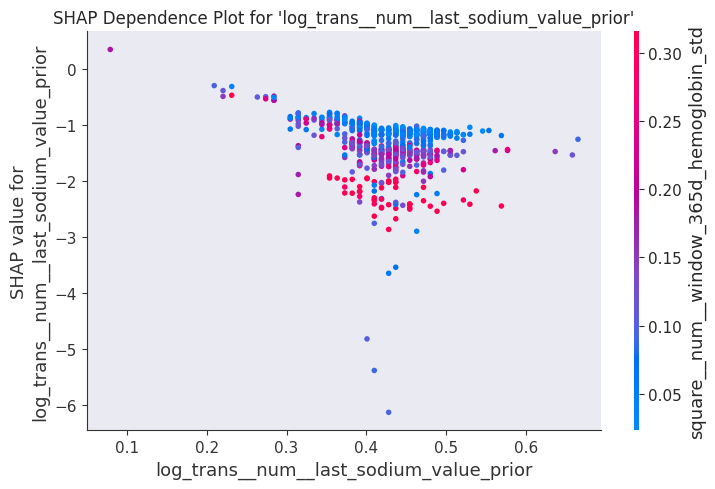

In [ ]:
# 5. Feature Dependence Plots (Example for top features)
#    Shows how a feature's value affects its SHAP value (impact on prediction)
#    Optionally colors by interaction with another feature.
print("Generating SHAP Dependence Plots for top features...")

# Get features sorted by mean absolute SHAP value
if isinstance(shap_values, list):
    # For multi-class, calculate mean abs SHAP across all classes or pick one class
    mean_abs_shap = pd.DataFrame(abs(shap_values[1]), columns=final_X_test.columns).mean()
else:
    mean_abs_shap = pd.DataFrame(abs(shap_values), columns=final_X_test.columns).mean()

top_features = mean_abs_shap.sort_values(ascending=False).index.tolist()

# Plot for the top 2 features (adjust number as needed)
for feature in top_features[:2]:
    plt.figure()
    shap.dependence_plot(
        feature,
        shap_values,
        final_X_test,
        interaction_index="auto", # Automatically selects interacting feature
        show=False
    )
    plt.title(f"SHAP Dependence Plot for '{feature}'")
    plt.tight_layout()
    plt.show();